# Bottled Gazpacho Market Research 3 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-15 17:47:15
Current date and time (UTC):   2025-07-15 20:47:15

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4o-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 16000
temperature = 0.7
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_na

In [2]:
config_manager.update("action_generator_enable_quality_checks", True)
config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [ ]:
control.begin("bottled_gazpacho_market_research_3.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values.
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.
"""
  

Should we also compute the other nationalities? This might take a while, so we leave it as an option.

In [5]:
compute_other_nationalities = True

Descriptions and standard questions for the survey.

In [6]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 0 to 4), where:
       - 0: would NEVER buy it
       - 1: very unlikely, but not impossible
       - 2: maybe I would buy it, not sure
       - 3: it is very likely
       - 4: would CERTAINLY buy it
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.
    """

Common mechaniss.

In [7]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '0', '1', '2', '3', '4' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [8]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category
    percentage_positive = percentage.get("3", 0) + percentage.get("4", 0)
    percentage_neutral = percentage.get("2", 0)
    percentage_negative = percentage.get("0", 0) + percentage.get("1", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (3-4): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (0-1): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [9]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [10]:
people = factory.generate_people(population_size, verbose=True)

2025-07-15 17:48:54,278 - tinytroupe - ERROR - Error occurred while extracting JSON: Expecting ',' delimiter: line 30 column 49 (char 1400). Input text: [
    {
        "id": 1,
        "sampled_values": {
            "age": [0, 18],
            "gender": "Male",
            "racial_and_ethnic_composition": ["White (Non-Hispanic)", "Hispanic or Latino"],
            "educational_attainment": "High School Graduate or Higher",
            "household_income": ["Under $25,000", "$25,000-$49,999"],
            "urban_rural_distribution": "Urban",
            "marital_status": "Never Married",
            "employment_status": "Labor Force Participation Rate",
            "culinary_tastes": ["Enjoys traditional American dishes", "Favors mild flavors and comfort foods"],
            "shopping_habits": ["Shops frequently", "Is a frugal shopper"],
            "health_consciousness": "Is indulgent in dietary habits",
            "attitude_towards_new_products": "Is open-minded and eager to try ne

ValueError: Postcondition not met for function <lambda>!

In [ ]:
factory.sampling_dimensions

{'sampling_space_description': 'A detailed overview of the population demographics, traits, and habits of the United States of America.',
 'dimensions': [{'name': 'age', 'range': [0, 100]},
  {'name': 'gender', 'values': {'Male': 0.492, 'Female': 0.508}},
  {'name': 'racial_and_ethnic_composition',
   'values': {'White (Non-Hispanic)': 0.571,
    'Hispanic or Latino': 0.194,
    'Black or African American': 0.121,
    'Asian': 0.07,
    'Two or More Races': 0.029,
    'American Indian or Alaska Native': 0.013,
    'Native Hawaiian or Pacific Islander': 0.002}},
  {'name': 'educational_attainment',
   'values': {'High School Graduate or Higher': 0.9,
    "Bachelor's Degree or Higher": 0.35}},
  {'name': 'household_income',
   'values': {'Under $25,000': 0.172,
    '$25,000-$49,999': 0.223,
    '$50,000-$99,999': 0.293,
    '$100,000-$199,999': 0.235,
    '$200,000 and Over': 0.077}},
  {'name': 'urban_rural_distribution',
   'values': {'Urban': 0.83, 'Rural': 0.17}},
  {'name': 'marital

In [ ]:
factory.sampling_plan

[{'id': 1,
  'sampled_values': {'age': [0, 18],
   'gender': 'Male',
   'racial_and_ethnic_composition': 'White (Non-Hispanic)',
   'educational_attainment': 'High School Graduate or Higher',
   'household_income': 'Under $25,000',
   'urban_rural_distribution': 'Urban',
   'marital_status': 'Never Married',
   'employment_status': 'Labor Force Participation Rate',
   'culinary_tastes': ['Enjoys traditional American dishes such as meatloaf and apple pie, often prepared with family recipes passed down through generations.'],
   'shopping_habits': ['Shops frequently, often visiting stores multiple times a week to keep up with the latest trends and sales.'],
   'health_consciousness': ['Is highly health-focused, prioritizing a balanced diet and regular exercise as essential components of their lifestyle.'],
   'attitude_towards_new_products': ['Is open-minded and eager to try new products, often being an early adopter of the latest trends and innovations.'],
   'cultural_influences': ['Is

We can request a specific number of people.

A quick look into the folks that were created:

In [ ]:
factory.generated_minibios

['Liam Alexander Thompson is a 17 year old Part-time Retail Associate, American, currently living in Chicago, Illinois. Liam is not only dedicated to his work and studies but also possesses a vibrant personality that draws people in. His optimistic outlook and sociable nature make him a favorite among customers and coworkers alike, as he often uses humor to lighten the mood. Outside of work, he enjoys staying active through sports and outdoor activities, reflecting his commitment to a healthy lifestyle. With a passion for cooking, he loves experimenting with family recipes, often bringing friends and family together over delicious meals, which highlights his belief in the importance of community and connection.',
 'Landon Michael Thompson is a 17 year old Part-time Retail Associate, American, currently living in Chicago, Illinois. Landon is a vibrant and sociable individual who thrives on human connection, often using his friendly demeanor and humor to engage with others. His passion f

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [ ]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [ ]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [ ]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Liam Alexander Thompson: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Landon Michael Thompson

       + --> Lucía Gabriela Ortega-Salazar

       + --> ...others...

USER --> Liam Alexander Thompson: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 0 to 4), where:        - 0: would
          > NEVER buy it        - 1: very unlikely, but not impossible        - 2: maybe I would buy
          > it, not sure        - 3: it is very likely        - 4: would CERTAINLY buy it

       + --> Landon Michael Thompson

       + --> Lucía Gabriela Ortega-Salazar

       + --> ...others...

Liam Alexander Thompson --> Liam Alexander Thompson: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Landon Michael Thompson --> Landon Michael Thompson: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Lucía Gabriela Ortega-Salazar --> Lucía Gabriela Ortega-Salazar: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Jamal Anthony Rivers --> Jamal Anthony Rivers: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Darnell Avery Johnson --> Darnell Avery Johnson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Isabella Sofia Martinez-Rivera --> Isabella Sofia Martinez-Rivera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Jamal Anthony Carter-Smithson --> Jamal Anthony Carter-Smithson: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Harold Benjamin Whitaker --> Harold Benjamin Whitaker: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.

Lucía Mariana Torres-Salinas --> Lucía Mariana Torres-Salinas: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Eugene Franklin Whitaker --> Eugene Franklin Whitaker: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.

Marcus Jamal Thompson-Smith --> Marcus Jamal Thompson-Smith: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Hana Mei Lin --> Hana Mei Lin: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests.      Now I **must** first THINK deeply about the question, consider
                  > all the factors that might influence my decision,     and only then I will TALK
                  > with my response to the question as best, as detailed and as honestly as I can.

Malik Jamal Washington --> Malik Jamal Washington: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Valentina Sofia Herrera-Morales --> Valentina Sofia Herrera-Morales: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Ethan Jameson --> Ethan Jameson: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests.      Now I **must** first THINK deeply about the question, consider
                   > all the factors that might influence my decision,     and only then I will TALK
                   > with my response to the question as best, as detailed and as honestly as I can.

Darius Malik Johnson --> Darius Malik Johnson: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Malik Jamal Carter-Smith --> Malik Jamal Carter-Smith: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.

Isabella Maria Gonzalez-Ramirez --> Isabella Maria Gonzalez-Ramirez: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Jamal Anthony Williams --> Jamal Anthony Williams: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Sofia Elena Ramirez-Castillo --> Sofia Elena Ramirez-Castillo: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Jamal Malik Henderson --> Jamal Malik Henderson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Marisol Elena Castillo-Rivera --> Marisol Elena Castillo-Rivera: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Yuki Mei Tanaka-Smithson --> Yuki Mei Tanaka-Smithson: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.

Sofia Valentina Cruz-Morales --> Sofia Valentina Cruz-Morales: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Henry Caldwell-Smith --> Henry Caldwell-Smith: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Liam Carter-James --> Liam Carter-James: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Malik Jamal Robinson --> Malik Jamal Robinson: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Mariana Isabel Torres-Salazar --> Mariana Isabel Torres-Salazar: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Lian Mei Chen-Smith --> Lian Mei Chen-Smith: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.

Lucía Gabriela Morales-Sánchez --> Lucía Gabriela Morales-Sánchez: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Miyuki Tanaka-Smithson --> Miyuki Tanaka-Smithson: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Valeria Sofia Mendoza-Rivera --> Valeria Sofia Mendoza-Rivera: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Isabella Maria Torres-Delgado --> Isabella Maria Torres-Delgado: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Sofia Elena Martinez-Garcia --> Sofia Elena Martinez-Garcia: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Sofia Elena Ramirez-Aguilar --> Sofia Elena Ramirez-Aguilar: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Marisol Elena Vargas-Ramirez --> Marisol Elena Vargas-Ramirez: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Lucía Elena Morales-Soto --> Lucía Elena Morales-Soto: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.

Oliver Bennett --> Oliver Bennett: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests.      Now I **must** first THINK deeply about the question, consider
                    > all the factors that might influence my decision,     and only then I will
                    > TALK with my response to the question as best, as detailed and as honestly as
                    > I can.

Ethan Mitchell-Smith --> Ethan Mitchell-Smith: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Tariq Jamal Carter --> Tariq Jamal Carter: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Harold Thompson-Smith --> Harold Thompson-Smith: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Yuki Harada-Smith --> Yuki Harada-Smith: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Jamal Anthony Robinson --> Jamal Anthony Robinson: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Claudia Isabel Ramirez-Delgado --> Claudia Isabel Ramirez-Delgado: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Darnell Mitchell-Smith --> Darnell Mitchell-Smith: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Valeria Sofia Gonzalez --> Valeria Sofia Gonzalez: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Miyuki Tanaka-Jones --> Miyuki Tanaka-Jones: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.

Ana María López-Sánchez --> Ana María López-Sánchez: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Sakura Tanaka-Wong --> Sakura Tanaka-Wong: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Yuki Sato-Williams --> Yuki Sato-Williams: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Ethan Caldwell-Smith --> Ethan Caldwell-Smith: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Franklin Hargrove --> Franklin Hargrove: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Hana Kimura --> Hana Kimura: [THOUGHT] 
                 >      I will be honest as I understand they are not here to judge me, but just to
                 > learn from me.      Such choices depend on many factors, but I will make my best
                 > guess, considering my current      situation in life, location, job and
                 > interests.      Now I **must** first THINK deeply about the question, consider
                 > all the factors that might influence my decision,     and only then I will TALK
                 > with my response to the question as best, as detailed and as honestly as I can.

Yuki Harada-Kim --> Yuki Harada-Kim: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests.      Now I **must** first THINK deeply about the question,
                     > consider all the factors that might influence my decision,     and only then
                     > I will TALK with my response to the question as best, as detailed and as
                     > honestly as I can.

Malcolm Jefferson --> Malcolm Jefferson: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Desmond Avery --> Desmond Avery: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests.      Now I **must** first THINK deeply about the question, consider
                   > all the factors that might influence my decision,     and only then I will TALK
                   > with my response to the question as best, as detailed and as honestly as I can.

Lucía Elena Torres-Morales --> Lucía Elena Torres-Morales: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests.      Now I
                                > **must** first THINK deeply about the question, consider all the
                                > factors that might influence my decision,     and only then I will
                                > TALK with my response to the question as best, as detailed and as
                                > honestly as I can.

Isabella Jiménez-Rojas --> Isabella Jiménez-Rojas: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Mei-Ling Chen-Wong --> Mei-Ling Chen-Wong: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Valeria Isabel Torres --> Valeria Isabel Torres: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Darius Mitchell --> Darius Mitchell: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests.      Now I **must** first THINK deeply about the question,
                     > consider all the factors that might influence my decision,     and only then
                     > I will TALK with my response to the question as best, as detailed and as
                     > honestly as I can.

Mariana Delgado-Rivera --> Mariana Delgado-Rivera: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Jacob Harrison --> Jacob Harrison: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests.      Now I **must** first THINK deeply about the question, consider
                    > all the factors that might influence my decision,     and only then I will
                    > TALK with my response to the question as best, as detailed and as honestly as
                    > I can.

Aiko Tanaka-Smith --> Aiko Tanaka-Smith: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Sofia Elena Vargas --> Sofia Elena Vargas: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Marcus Jamal Thompson --> Marcus Jamal Thompson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Charles Whitmore --> Charles Whitmore: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests.      Now I **must** first THINK deeply about the
                      > question, consider all the factors that might influence my decision,     and
                      > only then I will TALK with my response to the question as best, as detailed
                      > and as honestly as I can.

Richard Caldwell --> Richard Caldwell: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests.      Now I **must** first THINK deeply about the
                      > question, consider all the factors that might influence my decision,     and
                      > only then I will TALK with my response to the question as best, as detailed
                      > and as honestly as I can.

Darnell Washington --> Darnell Washington: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Lucía González-Morales --> Lucía González-Morales: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Camila Ramirez-Soto --> Camila Ramirez-Soto: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.

Gabriela Mendoza-López --> Gabriela Mendoza-López: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Liam Anderson --> Liam Anderson: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests.      Now I **must** first THINK deeply about the question, consider
                   > all the factors that might influence my decision,     and only then I will TALK
                   > with my response to the question as best, as detailed and as honestly as I can.

Jamal Carter --> Jamal Carter: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests.      Now I **must** first THINK deeply about the question, consider
                  > all the factors that might influence my decision,     and only then I will TALK
                  > with my response to the question as best, as detailed and as honestly as I can.

Ethan Parker --> Ethan Parker: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests.      Now I **must** first THINK deeply about the question, consider
                  > all the factors that might influence my decision,     and only then I will TALK
                  > with my response to the question as best, as detailed and as honestly as I can.

Yuki Tanaka --> Yuki Tanaka: [THOUGHT] 
                 >      I will be honest as I understand they are not here to judge me, but just to
                 > learn from me.      Such choices depend on many factors, but I will make my best
                 > guess, considering my current      situation in life, location, job and
                 > interests.      Now I **must** first THINK deeply about the question, consider
                 > all the factors that might influence my decision,     and only then I will TALK
                 > with my response to the question as best, as detailed and as honestly as I can.

Lian Chen --> Lian Chen: [THOUGHT] 
               >      I will be honest as I understand they are not here to judge me, but just to
               > learn from me.      Such choices depend on many factors, but I will make my best
               > guess, considering my current      situation in life, location, job and interests.
               > Now I **must** first THINK deeply about the question, consider all the factors that
               > might influence my decision,     and only then I will TALK with my response to the
               > question as best, as detailed and as honestly as I can.

Walter Hargrove --> Walter Hargrove: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests.      Now I **must** first THINK deeply about the question,
                     > consider all the factors that might influence my decision,     and only then
                     > I will TALK with my response to the question as best, as detailed and as
                     > honestly as I can.

Isabella Torres-Mendoza --> Isabella Torres-Mendoza: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Eugene Thompson --> Eugene Thompson: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests.      Now I **must** first THINK deeply about the question,
                     > consider all the factors that might influence my decision,     and only then
                     > I will TALK with my response to the question as best, as detailed and as
                     > honestly as I can.

Valentina Cruz-Sanchez --> Valentina Cruz-Sanchez: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Harold Whitaker --> Harold Whitaker: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests.      Now I **must** first THINK deeply about the question,
                     > consider all the factors that might influence my decision,     and only then
                     > I will TALK with my response to the question as best, as detailed and as
                     > honestly as I can.

Malik Johnson --> Malik Johnson: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests.      Now I **must** first THINK deeply about the question, consider
                   > all the factors that might influence my decision,     and only then I will TALK
                   > with my response to the question as best, as detailed and as honestly as I can.

Sofia Martinez-Rivera --> Sofia Martinez-Rivera: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Mei-Ling Nakamura --> Mei-Ling Nakamura: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

In [ ]:
market.run(1)

───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

Liam Alexander Thompson acts: [THINK] 
                             > I need to consider my personal preferences and lifestyle when it
                             > comes to purchasing ready-to-drink bottled gazpacho. I enjoy trying
                             > new foods, especially healthy options, and I appreciate convenience
                             > due to my busy schedule with work and college. However, I also value
                             > fresh ingredients and homemade meals. I should weigh these factors
                             > carefully before responding.

Lucía Mariana Torres-Salinas acts: [TALK] 
                                  > I appreciate the opportunity to share my thoughts! My name is
                                  > Lucía Mariana Torres-Salinas, and I'm a 27-year-old culinary
                                  > artist based in Mexico City. I have a strong passion for
                                  > culinary arts, traveling, and cultural festivals. As for the
                                  > gazpacho, I think it's a refreshing and healthy option,
                                  > especially during hot weather. I would rate my propensity to
                                  > purchase ready-to-drink bottled gazpacho as a 3: it is very
                                  > likely that I would buy it if it were available at my local
                                  > supermarket. I enjoy trying new products that align with my
                                  > interests in sustainable and fresh food options.

Marcus Jamal Thompson-Smith acts: [TALK] 
                                 > I appreciate the opportunity to share my thoughts. My name is
                                 > Marcus Jamal Thompson-Smith, and I'm a 39-year-old warehouse
                                 > worker living in Atlanta, Georgia. I have a strong interest in
                                 > cooking, especially when it comes to experimenting with spicy
                                 > dishes. As for the gazpacho, I think it's a refreshing option,
                                 > especially during the hot months. I would rate my propensity to
                                 > purchase ready-to-drink bottled gazpacho as a 2. I might consider
                                 > buying it if it’s available, but it would depend on the price and
                                 > how it compares to making it fresh myself.

Isabella Sofia Martinez-Rivera acts: [TALK] 
                                    > I appreciate the opportunity to share about myself! My name is
                                    > Isabella Sofia Martinez-Rivera, and I'm a 27-year-old culinary
                                    > artist based in Los Angeles, California. I work as a freelance
                                    > culinary artist, creating unique dishes that blend various
                                    > culinary traditions. My top-10 interests include: 1. Culinary
                                    > arts, 2. Traveling, 3. Cultural festivals, 4. Food
                                    > photography, 5. Sustainable living, 6. Exploring new
                                    > restaurants and food markets, 7. Cooking with fresh, local
                                    > ingredients, 8. Attending food and wine festivals, 9. Trying
                                    > out new recipes and techniques, and 10. Sharing meals with
                                    > friends and family.

Harold Benjamin Whitaker acts: [THINK] 
                              > I need to consider my feelings about gazpacho. I enjoy fresh, home-
                              > cooked meals, and I appreciate the use of organic ingredients.
                              > However, I have always preferred making things from scratch rather
                              > than buying pre-made products. I also think about how often I would
                              > actually consume a ready-to-drink soup like gazpacho. It might be
                              > convenient, but I wonder if it would taste as good as the one I
                              > could make myself. I should also consider the availability of fresh
                              > ingredients for making it at home. Overall, I feel a bit skeptical
                              > about purchasing it, but I can see some appeal in having it
                              > available for those hot summer days when I don't feel like cooking.
                              > I will rate my propensity to purchase it accordingly.

Lucía Gabriela Ortega-Salazar acts: [TALK] 
                                   > I appreciate the opportunity to share my thoughts! My name is
                                   > Lucía Gabriela Ortega-Salazar, and I'm a 32-year-old marketing
                                   > specialist based in Mexico City. I have a Bachelor's in
                                   > Business Administration and a diploma in Marketing Strategies.
                                   > My top interests include culinary arts, especially traditional
                                   > Mexican cooking, traveling and exploring new cultures, social
                                   > media trends, and sustainability initiatives.   Regarding the
                                   > gazpacho, I think it's a refreshing idea, especially for the
                                   > hot weather we often have here. I would rate my propensity to
                                   > purchase ready-to-drink bottled gazpacho as a 3: it is very
                                   > likely. I enjoy trying new products that align with my interest
                                   > in healthy eating and cultural cuisine!

Landon Michael Thompson acts: [THINK] 
                             > I need to consider my personal preferences and lifestyle when it
                             > comes to purchasing ready-to-drink bottled gazpacho. I enjoy trying
                             > new foods and experimenting with different cuisines, so the idea of
                             > having a cold vegetable soup sounds appealing, especially during
                             > warmer months. However, I also think about factors like convenience,
                             > price, and whether it fits into my healthy eating habits. Given that
                             > I often cook for myself and enjoy fresh ingredients, I might be
                             > inclined to buy it if it's reasonably priced and available at my
                             > local supermarket. Overall, I would rate my propensity to purchase it
                             > as a 3: it is very likely, but I would need to see how it fits into
                             > my routine.

Jamal Anthony Carter-Smithson acts: [THINK] 
                                   > I need to consider my feelings about gazpacho and whether I
                                   > would buy it if it were available in stores. I enjoy trying new
                                   > foods, especially those that are flavorful and healthy.
                                   > Gazpacho sounds refreshing, especially in the hot Atlanta
                                   > weather. However, I also prefer fresh, homemade meals over
                                   > processed options. I should weigh my interest in the product
                                   > against my usual preferences for cooking and eating. Overall, I
                                   > think I would be open to trying it, but I need to be honest
                                   > about my likelihood of purchasing it regularly.

Jamal Anthony Rivers acts: [TALK] 
                          > I appreciate the opportunity to share my thoughts. My name is Jamal
                          > Anthony Rivers, I'm 39 years old, and I work as a construction worker in
                          > Atlanta, Georgia. I enjoy cooking, especially experimenting with spicy
                          > recipes, and I love watching sports like football and basketball. As for
                          > the gazpacho, I think it's a refreshing idea, especially during the hot
                          > months. I would rate my propensity to purchase ready-to-drink bottled
                          > gazpacho as a 2. It's something I might consider buying, but it would
                          > depend on the price and availability at my local supermarket.

Darnell Avery Johnson acts: [THINK] 
                           > I need to consider my personal preferences and lifestyle when it comes
                           > to purchasing ready-to-drink bottled gazpacho. I enjoy cooking and
                           > trying new recipes, but I also appreciate convenience due to my busy
                           > work schedule. Gazpacho sounds refreshing, especially in the hot
                           > Atlanta weather, and I like the idea of having a healthy option
                           > available. However, I need to think about the price and whether it fits
                           > into my budget. Overall, I think I would be open to trying it if it was
                           > reasonably priced and available at my local supermarket.

Hana Mei Lin acts: [TALK] 
                  > I appreciate the opportunity to share my thoughts! My name is Hana Mei Lin, and
                  > I am a 54-year-old Chinese-American marketing manager living in San Francisco. I
                  > have a passion for culinary arts, traveling, and cultural exchange. Here are my
                  > top-10 interests: 1. Culinary arts 2. Traveling 3. Yoga and fitness 4. Cultural
                  > festivals 5. Photography 6. Exploring local markets 7. Attending food and wine
                  > festivals 8. Cooking new recipes 9. Volunteering at food banks 10. Learning
                  > about different cultures.

Eugene Franklin Whitaker acts: [TALK] 
                              > Well, my name is Eugene Franklin Whitaker. I'm a 75-year-old retired
                              > farmer living in rural Virginia. I spent most of my life working the
                              > land, and even though I'm not actively farming anymore, I still tend
                              > to a small vegetable garden. I enjoy sharing my produce with my
                              > neighbors and staying connected with my community. As for my
                              > interests, I would say they include gardening, fishing, local
                              > history, family gatherings, and participating in community events.
                              > Now, regarding the gazpacho, I appreciate the idea of having ready-
                              > to-drink bottled gazpacho available at my local supermarket. I would
                              > rate my propensity to purchase it as a 2, maybe I would buy it, but
                              > I'm not entirely sure. It really depends on the quality and how it
                              > aligns with my preference for fresh, home-cooked meals made with
                              > organic ingredients.

Liam Alexander Thompson acts: [TALK] 
                             > I appreciate the opportunity to share my thoughts! I would rate my
                             > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is
                             > very likely that I would buy it, especially if it’s made with fresh
                             > ingredients and is convenient for my busy lifestyle. I enjoy trying
                             > new foods, and gazpacho sounds like a refreshing option, especially
                             > during warmer months.

Harold Benjamin Whitaker acts: [TALK] 
                              > I appreciate the opportunity to share my thoughts. As a retired
                              > farmer, I value fresh, home-cooked meals made with organic
                              > ingredients. While I can see the convenience of ready-to-drink
                              > bottled gazpacho, I must admit that I prefer making things from
                              > scratch. However, I would rate my propensity to purchase it as a 2,
                              > meaning maybe I would buy it, but I'm not entirely sure. It would
                              > depend on the quality and taste compared to what I could make
                              > myself.

Liam Alexander Thompson acts: [DONE] 

Harold Benjamin Whitaker acts: [DONE] 

Jamal Anthony Rivers acts: [DONE] 

Landon Michael Thompson acts: [TALK] 
                             > I appreciate the opportunity to share my thoughts! My name is Landon
                             > Michael Thompson, and I'm 17 years old. I currently work part-time at
                             > a local grocery store while pursuing an associate degree in Business
                             > Administration at community college. As for my top-10 interests, they
                             > include: 1) Sports, particularly basketball and soccer, 2) Cooking
                             > and experimenting with new recipes, 3) Video games and technology, 4)
                             > Community service and volunteering, 5) Outdoor activities like hiking
                             > and biking, 6) Listening to music, especially pop and hip-hop, 7)
                             > Trying new foods and cuisines, 8) Spending time with friends and
                             > family, 9) Learning about business management, and 10) Traveling to
                             > experience different cultures.

Lucía Gabriela Ortega-Salazar acts: [DONE] 

Lucía Mariana Torres-Salinas acts: [DONE] 

Isabella Sofia Martinez-Rivera acts: [TALK] 
                                    > Regarding the ready-to-drink bottled gazpacho, I think it's a
                                    > fantastic idea! Gazpacho is refreshing and perfect for warm
                                    > weather, and I appreciate the convenience of having it ready
                                    > to drink. I would rate my propensity to purchase it as a 3: it
                                    > is very likely. I often look for healthy and flavorful
                                    > options, and this fits perfectly with my culinary interests
                                    > and lifestyle.

Marcus Jamal Thompson-Smith acts: [DONE] 

Jamal Anthony Carter-Smithson acts: [TALK] 
                                   > I appreciate the opportunity to share my thoughts. I would rate
                                   > my propensity to purchase ready-to-drink bottled gazpacho as a
                                   > 2. I might consider buying it, but I'm not entirely sure. I
                                   > enjoy trying new foods, especially refreshing ones like
                                   > gazpacho, but I usually prefer fresh, homemade meals over
                                   > processed options. If it were available, I would be open to
                                   > giving it a try, especially during the hot summer months.

Hana Mei Lin acts: [TALK] 
                  > Regarding the idea of purchasing ready-to-drink bottled gazpacho, I would rate
                  > my propensity to buy it as a 3: it is very likely. I enjoy trying new food
                  > products, especially those that are healthy and refreshing. Gazpacho sounds
                  > appealing, particularly during warm weather, and I appreciate the convenience of
                  > ready-to-drink options. However, I would also consider factors like the quality
                  > of ingredients and the price before making a final decision.

Eugene Franklin Whitaker acts: [DONE] 

Darnell Avery Johnson acts: [TALK] 
                           > I appreciate the opportunity to share my thoughts. I would rate my
                           > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is
                           > very likely that I would buy it, especially if it’s reasonably priced
                           > and available at my local supermarket. I enjoy trying new foods, and
                           > gazpacho sounds like a refreshing option, particularly in the summer.
                           > However, I would need to consider the quality and ingredients before
                           > making a final decision.

Isabella Sofia Martinez-Rivera acts: [DONE] 

Jamal Anthony Carter-Smithson acts: [DONE] 

Hana Mei Lin acts: [DONE] 

Isabella Maria Gonzalez-Ramirez acts: [TALK] 
                                     > I appreciate the opportunity to share about myself! My name
                                     > is Isabella Maria Gonzalez-Ramirez, and I'm a 32-year-old
                                     > marketing specialist living in Los Angeles, California. I
                                     > have a Bachelor's degree in Business Administration with a
                                     > focus on Marketing and Consumer Behavior from California
                                     > State University. My top-10 interests include: 1. Culinary
                                     > arts, 2. Traveling, 3. Cultural events, 4. Social media
                                     > trends, 5. Sustainability initiatives, 6. Cooking and trying
                                     > new recipes, 7. Attending food festivals, 8. Spending time
                                     > with family and friends, 9. Exploring local markets, and 10.
                                     > Listening to music from various genres.

Darnell Avery Johnson acts: [DONE] 

Ethan Jameson acts: [THINK] 
                   > I need to consider my thoughts on gazpacho. I enjoy healthy foods and trying
                   > new things, but I also have to think about my budget and whether I would
                   > actually buy it. I like the idea of having a refreshing soup option, especially
                   > in the summer. However, I need to weigh how often I would actually purchase it
                   > and if it fits into my lifestyle. Overall, I think I would be open to trying it
                   > if it was available.

Valentina Sofia Herrera-Morales acts: [TALK] 
                                     > I appreciate the opportunity to share my thoughts! My name is
                                     > Valentina Sofia Herrera-Morales, and I'm a 27-year-old
                                     > culinary artist based in Los Angeles. I specialize in modern
                                     > fusion cuisine and love experimenting with flavors from
                                     > different cultures. As for my top interests, they include
                                     > culinary arts, traveling, cultural festivals, food
                                     > photography, and sustainable living. Regarding the gazpacho,
                                     > I think it's a refreshing and healthy option, especially
                                     > during warm weather. I would rate my propensity to purchase
                                     > ready-to-drink bottled gazpacho as a 3—it is very likely that
                                     > I would buy it if it were available at my local supermarket!

Landon Michael Thompson acts: [TALK] 
                             > Regarding the bottled gazpacho, I think it's a great idea! I would
                             > rate my propensity to purchase it as a 3: it is very likely. I enjoy
                             > trying new foods, and having a ready-to-drink option would be
                             > convenient, especially during the summer months when I prefer lighter
                             > meals. If it's reasonably priced and available at my local
                             > supermarket, I would definitely consider buying it.

Darius Malik Johnson acts: [THINK] 
                          > I need to consider my feelings about gazpacho and whether I would buy
                          > it. I enjoy trying new foods, especially those with bold flavors, but I
                          > also have to think about convenience and my current lifestyle. Ready-to-
                          > drink options can be appealing if they are tasty and healthy. I should
                          > also consider how often I would actually want to buy it and if it fits
                          > into my budget. Overall, I think I might be open to the idea, but I need
                          > to rate it carefully based on my preferences and situation.

Malik Jamal Carter-Smith acts: [TALK] 
                              > I appreciate the opportunity to share my thoughts. My name is Malik
                              > Jamal Carter-Smith, and I'm a 38-year-old warehouse worker living in
                              > Atlanta, Georgia. I have a strong passion for cooking, especially
                              > when it comes to experimenting with spicy dishes from various
                              > cultures. As for my top interests, they include: 1. Cooking and
                              > experimenting with new recipes, 2. Exploring different cultures
                              > through food, 3. Watching cooking shows and food documentaries, 4.
                              > Listening to music, especially hip-hop and R&B, 5. Visiting local
                              > markets for fresh ingredients, 6. Outdoor barbecues and gatherings,
                              > 7. Engaging in conversations about food with friends and family, 8.
                              > Learning about nutrition and healthy eating, 9. Traveling to
                              > experience culinary traditions firsthand, and 10. Keeping a journal
                              > of favorite recipes and cooking tips.

Landon Michael Thompson acts: [DONE] 

Jamal Anthony Williams acts: [TALK] 
                            > I appreciate the opportunity to share about myself. My name is Jamal
                            > Anthony Williams, I'm 39 years old, and I work as a construction
                            > worker in Atlanta, Georgia. I take pride in my work and am always
                            > looking for ways to improve my skills and advance in my career. As for
                            > my top-10 interests, they include: 1. Cooking, especially
                            > experimenting with spicy recipes; 2. Watching sports, particularly
                            > basketball and football; 3. Spending time outdoors, especially in
                            > parks or at barbecues; 4. Listening to hip-hop and R&B music; 5.
                            > Engaging in community events and gatherings; 6. Watching documentaries
                            > and learning about different cultures; 7. Trying out new restaurants;
                            > 8. Spending time with my children; 9. DIY home improvement projects;
                            > 10. Volunteering in local charities.

Malik Jamal Carter-Smith acts: [TALK] 
                              > Regarding the idea of purchasing ready-to-drink bottled gazpacho, I
                              > would rate my propensity to buy it as a 2. I think it could be a
                              > refreshing option, especially during the hot summer months, but it
                              > would depend on the quality and flavor. If it tastes good and is
                              > made with quality ingredients, I might consider buying it
                              > occasionally, but I wouldn't rely on it as a staple in my diet.

Yuki Mei Tanaka-Smithson acts: [TALK] 
                              > I appreciate the opportunity to share about myself. My name is Yuki
                              > Mei Tanaka-Smithson, and I am a 54-year-old Japanese-American
                              > cultural consultant based in San Francisco. I work with Global
                              > Connections Inc., helping businesses navigate cultural differences
                              > in international markets. My top interests include culinary arts,
                              > especially international cuisines, traveling and exploring new
                              > cultures, yoga and mindfulness practices, art and photography,
                              > attending cultural festivals, reading travel memoirs, and promoting
                              > cultural understanding through community events.   Regarding the
                              > gazpacho, I think it's a refreshing idea! I would rate my propensity
                              > to purchase ready-to-drink bottled gazpacho at a 3: it is very
                              > likely. I enjoy trying new foods, especially those that reflect
                              > different cultures, and gazpacho sounds like a delightful option for
                              > warm days.

Isabella Maria Gonzalez-Ramirez acts: [TALK] 
                                     > Regarding the ready-to-drink bottled gazpacho, I would rate
                                     > my propensity to purchase it as a 3. It is very likely that I
                                     > would buy it, especially if it is made with fresh ingredients
                                     > and has a good flavor. I enjoy gazpacho, particularly during
                                     > the warmer months, and having a convenient option available
                                     > at my local supermarket would definitely appeal to me.

Malik Jamal Carter-Smith acts: [DONE] 

Ethan Jameson acts: [TALK] 
                   > I appreciate the opportunity to share my thoughts! My name is Ethan Jameson,
                   > I'm 17 years old, and I currently work part-time at a local grocery store while
                   > pursuing an Associate's degree in Business Administration. As for my interests,
                   > I really enjoy fitness and sports, particularly basketball and running. I also
                   > love cooking and experimenting with healthy recipes, exploring local music
                   > scenes, and volunteering at community events. Regarding the gazpacho, I think I
                   > would rate my propensity to purchase it as a 3. It's very likely that I would
                   > buy it, especially if it's a healthy option and convenient for my busy
                   > lifestyle.

Jamal Malik Henderson acts: [THINK] 
                           > I need to consider my thoughts on gazpacho. I enjoy trying new foods,
                           > especially those with a bit of spice or unique flavors. However, I also
                           > prefer fresh, homemade meals over pre-packaged options. I should think
                           > about how convenient it would be to have a ready-to-drink option
                           > available at the supermarket and whether it aligns with my busy
                           > lifestyle as a construction worker. I also need to consider the quality
                           > and taste of the product, as I dislike overly processed foods. Overall,
                           > I think I might be open to trying it, but I need to weigh the pros and
                           > cons carefully before making a decision.

Isabella Maria Gonzalez-Ramirez acts: [DONE] 

Sofia Valentina Cruz-Morales acts: [THINK] 
                                  > I need to consider my feelings about gazpacho and how it fits
                                  > into my lifestyle. I enjoy fresh, healthy foods, and gazpacho
                                  > aligns with my preference for culinary arts and traditional
                                  > Hispanic dishes. However, I also think about convenience and
                                  > whether I would actually purchase a ready-to-drink version. I
                                  > appreciate the idea of having it available, especially during
                                  > hot days or when I'm busy. I should rate my likelihood of
                                  > purchasing it based on these thoughts.

Sofia Elena Ramirez-Castillo acts: [THINK] 
                                  > I need to consider my feelings about gazpacho and how it fits
                                  > into my lifestyle. I enjoy fresh, healthy foods, and gazpacho
                                  > aligns with that. I appreciate the idea of having a convenient,
                                  > ready-to-drink option available at my local supermarket.
                                  > However, I also value authenticity and prefer homemade versions.
                                  > I should weigh these factors carefully before responding.

Ethan Jameson acts: [DONE] 

Marisol Elena Castillo-Rivera acts: [TALK] 
                                   > I appreciate the opportunity to share about myself! My name is
                                   > Marisol Elena Castillo-Rivera, and I'm a 34-year-old marketing
                                   > specialist living in Los Angeles, California. I have a
                                   > Bachelor's degree in Business Administration with a focus on
                                   > Marketing and Consumer Behavior. My top 10 interests include:
                                   > 1. Culinary arts, especially traditional Hispanic cooking, 2.
                                   > Community service and volunteer work, 3. Traveling to explore
                                   > different cultures and cuisines, 4. Attending cultural
                                   > festivals and events, 5. Outdoor activities like hiking and
                                   > picnics, 6. Listening to Latin music and dancing, 7.
                                   > Experimenting with new recipes, 8. Documenting my travels on
                                   > social media, 9. Promoting local businesses, and 10. Engaging
                                   > in mindfulness practices like yoga.

Yuki Mei Tanaka-Smithson acts: [DONE] 

Malik Jamal Washington acts: [THINK] 
                            > I need to consider my feelings about gazpacho and whether I would buy
                            > it if it were available in stores. I enjoy trying new foods,
                            > especially those that are flavorful and healthy. Gazpacho sounds
                            > refreshing, especially in the hot Atlanta weather. However, I usually
                            > prefer homemade meals over store-bought options. I should also think
                            > about the convenience of having a ready-to-drink option. Overall, I
                            > think I would be open to trying it, but I need to weigh my preferences
                            > for fresh, homemade food against the convenience of a bottled option.

Darius Malik Johnson acts: [TALK] 
                          > I appreciate the opportunity to share my thoughts. I would rate my
                          > propensity to purchase ready-to-drink bottled gazpacho as a 2. I think
                          > it could be a refreshing option, especially during the warmer months,
                          > but I would need to try it first to see if I like the flavor. It really
                          > depends on how convenient it is for me and if it fits into my budget.
                          > Overall, I'm open to the idea, but I'm not entirely sure yet.

Valentina Sofia Herrera-Morales acts: [DONE] 

Darius Malik Johnson acts: [DONE] 

Henry Caldwell-Smith acts: [THINK] 
                          > I need to consider my personal preferences and lifestyle when it comes
                          > to purchasing ready-to-drink bottled gazpacho. I enjoy fresh, home-
                          > cooked meals and prefer to eat healthy, so I might be inclined to try it
                          > if it aligns with my values. However, I also have a strong preference
                          > for homemade food, which could influence my decision. I should also
                          > think about the availability of fresh ingredients in my area and whether
                          > this product would be a convenient option for me.

Sofia Valentina Cruz-Morales acts: [TALK] 
                                  > I appreciate the idea of offering ready-to-drink bottled
                                  > gazpacho in supermarkets. I enjoy fresh and healthy foods, and
                                  > gazpacho is a great option, especially during hot days.
                                  > Considering my lifestyle and preferences, I would rate my
                                  > propensity to purchase it as a 3: it is very likely that I would
                                  > buy it if it were available at my local supermarket.

Marisol Elena Castillo-Rivera acts: [TALK] 
                                   > Regarding the ready-to-drink bottled gazpacho, I think it's a
                                   > great idea! I enjoy gazpacho, especially during the hot summer
                                   > months, as it's refreshing and healthy. If it were available at
                                   > my local supermarket, I would definitely consider purchasing
                                   > it. I would rate my propensity to buy it as a 3: it is very
                                   > likely. I appreciate convenience, and having a ready-to-drink
                                   > option would make it easier for me to enjoy this delicious dish
                                   > without the hassle of making it myself.

Liam Carter-James acts: [TALK] 
                       > I appreciate the opportunity to share about myself! My name is Liam Carter-
                       > James, I'm 17 years old, and I'm currently a high school student in
                       > Chicago. I have a passion for sports, particularly basketball and soccer,
                       > and I enjoy volunteering at local sports events. Here are my top-10
                       > interests: 1. Basketball 2. Soccer 3. Traveling 4. Community service 5.
                       > Cooking 6. Outdoor activities like hiking 7. Listening to music 8.
                       > Attending concerts 9. Exploring new cultures 10. Trying out new recipes.

Malik Jamal Robinson acts: [THINK] 
                          > I need to consider my feelings about gazpacho and whether I would buy
                          > it. I enjoy trying new foods, especially if they are healthy and
                          > flavorful. However, I also prefer fresh, homemade meals over pre-
                          > packaged options. I should think about how often I would actually
                          > purchase it and if it fits into my lifestyle. Given my busy work
                          > schedule, convenience might play a role in my decision.

Jamal Anthony Williams acts: [TALK] 
                            > You know, about the gazpacho, I’d say I’d rate my likelihood of buying
                            > it as a 2. It sounds like a refreshing option, especially when the
                            > summer heat kicks in. But honestly, I’m not sure if I’d grab it
                            > regularly. It really depends on the price and how it stacks up against
                            > making my own fresh batch. I love cooking, and there’s something
                            > special about whipping up a homemade version with all those spicy
                            > flavors! But hey, I appreciate the idea; it could be a fun addition to
                            > the supermarket shelves!

Mariana Isabel Torres-Salazar acts: [THINK] 
                                   > I need to consider my personal preferences and lifestyle when
                                   > it comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                   > culinary arts and trying new foods, especially those that
                                   > reflect my Hispanic heritage. Gazpacho is a traditional dish
                                   > that I appreciate, and having it available in a convenient
                                   > format could be appealing. However, I also value fresh
                                   > ingredients and the experience of making dishes myself. I
                                   > should weigh these factors carefully before responding.

Sofia Valentina Cruz-Morales acts: [DONE] 

Malik Jamal Washington acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts. I would rate my
                            > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might
                            > consider buying it, but I'm not entirely sure. I enjoy trying new
                            > foods, and gazpacho sounds refreshing, especially in the summer.
                            > However, I usually prefer homemade meals, so it would depend on the
                            > quality and flavor of the product. If it tastes good and is
                            > convenient, I could see myself buying it occasionally.

Marisol Elena Castillo-Rivera acts: [DONE] 

Lucía Gabriela Morales-Sánchez acts: [TALK] 
                                    > I appreciate the opportunity to share my thoughts! My name is
                                    > Lucía Gabriela Morales-Sánchez, and I'm a 27-year-old culinary
                                    > artist based in Mexico City. I have a passion for food and
                                    > culture, and I love experimenting with flavors from different
                                    > cuisines. As for my top-10 interests, they include: 1.
                                    > Culinary arts, 2. Traveling, 3. Cultural festivals, 4.
                                    > Photography, 5. Sustainable living, 6. Cooking with fresh,
                                    > local ingredients, 7. Attending food and cultural festivals,
                                    > 8. Trying out new recipes and techniques, 9. Spending time
                                    > with friends and family over meals, and 10. Exploring new
                                    > restaurants and food markets.

Lian Mei Chen-Smith acts: [TALK] 
                         > Hello! I'm Lian Mei Chen-Smith, a 54-year-old marketing manager at Global
                         > Foods Inc. I specialize in developing marketing strategies for
                         > international food products. My top-10 interests include culinary arts,
                         > traveling, yoga and fitness, cultural festivals, photography, exploring
                         > new restaurants, attending food and wine festivals, cooking, volunteering
                         > at food banks, and documenting my travels through a journal.   Regarding
                         > the gazpacho, I think it's a refreshing idea! I would rate my propensity
                         > to purchase ready-to-drink bottled gazpacho at a 3: it is very likely. I
                         > enjoy trying new food products, especially those that align with my
                         > interest in healthy eating and cultural cuisines.

Jamal Anthony Williams acts: [DONE] 

Henry Caldwell-Smith acts: [TALK] 
                          > I appreciate the information about gazpacho. Given my preference for
                          > fresh, home-cooked meals, I would rate my propensity to purchase ready-
                          > to-drink bottled gazpacho as a 2. I might consider buying it if it were
                          > available, but I'm not entirely sure. It would depend on the quality and
                          > whether it aligns with my values of healthy eating.

Sofia Elena Ramirez-Castillo acts: [TALK] 
                                  > I appreciate the idea of offering ready-to-drink bottled
                                  > gazpacho, especially since I enjoy fresh and healthy foods.
                                  > However, I also value authenticity in my meals. If the product
                                  > is made with high-quality, fresh ingredients, I would consider
                                  > purchasing it. I would rate my propensity to buy it as a 3: it
                                  > is very likely, but I would need to see the ingredients and
                                  > perhaps try it first.

Malik Jamal Robinson acts: [TALK] 
                          > I appreciate the idea of offering bottled gazpacho, as I enjoy trying
                          > new foods. However, I tend to prefer fresh, homemade meals over pre-
                          > packaged options. Considering my busy work schedule, convenience does
                          > play a role in my decision. I would rate my propensity to purchase it as
                          > a 2: maybe I would buy it, not sure. It would depend on the quality and
                          > taste of the product.

Jamal Malik Henderson acts: [TALK] 
                           > I appreciate the opportunity to share my thoughts. I would rate my
                           > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might
                           > consider buying it, but I'm not entirely sure. It really depends on the
                           > quality and taste of the product. If it’s fresh and flavorful, I could
                           > see myself picking it up for convenience, especially after a long day
                           > at work. However, I generally prefer homemade meals, so that would be a
                           > factor for me.

Henry Caldwell-Smith acts: [DONE] 

Malik Jamal Washington acts: [DONE] 

Jamal Malik Henderson acts: [DONE] 

Malik Jamal Robinson acts: [DONE] 

Liam Carter-James acts: [TALK] 
                       > Regarding the gazpacho, I think it's a really interesting idea! I would
                       > rate my propensity to purchase ready-to-drink bottled gazpacho as a 3,
                       > which means it is very likely. I enjoy trying new foods, especially healthy
                       > options, and gazpacho sounds refreshing, especially in the summer. If it's
                       > available at my local supermarket, I would definitely consider buying it!

Lucía Gabriela Morales-Sánchez acts: [TALK] 
                                    > Regarding the idea of purchasing ready-to-drink bottled
                                    > gazpacho, I would rate my propensity to buy it as a 3. It is
                                    > very likely that I would consider purchasing it, especially if
                                    > it is made with fresh, high-quality ingredients and aligns
                                    > with my values of sustainability. Gazpacho is a refreshing
                                    > option, and having it available in supermarkets would be
                                    > convenient for me, particularly during the warmer months when
                                    > I enjoy lighter meals.

Valeria Sofia Mendoza-Rivera acts: [TALK] 
                                  > I appreciate the opportunity to share my thoughts! My name is
                                  > Valeria Sofia Mendoza-Rivera, and I'm a 27-year-old culinary
                                  > artist based in Los Angeles. I specialize in modern fusion
                                  > cuisine and love experimenting with flavors from different
                                  > cultures. As for my top-10 interests, they include: 1. Culinary
                                  > arts, 2. Traveling, 3. Cultural festivals, 4. Food photography,
                                  > 5. Sustainable cooking practices, 6. Exploring new restaurants
                                  > and food markets, 7. Cooking with fresh, local ingredients, 8.
                                  > Attending food and wine festivals, 9. Sharing meals with friends
                                  > and family, and 10. Experimenting with new recipes and
                                  > techniques.

Lian Mei Chen-Smith acts: [DONE] 

Isabella Maria Torres-Delgado acts: [TALK] 
                                   > I appreciate the opportunity to share about myself! My name is
                                   > Isabella Maria Torres-Delgado, and I'm a 32-year-old marketing
                                   > specialist living in Los Angeles, California. I have a
                                   > Bachelor's degree in Business Administration with a focus on
                                   > Marketing and Consumer Behavior from California State
                                   > University. My top 10 interests include: 1. Culinary arts,
                                   > especially trying new recipes and cooking techniques, 2.
                                   > Traveling to new destinations and immersing myself in local
                                   > cultures, 3. Social media trends and influencer marketing, 4.
                                   > Sustainability and eco-friendly practices, 5. Outdoor
                                   > activities like hiking and picnicking, 6. Art and cultural
                                   > festivals, 7. Reading books about personal development and
                                   > cultural history, 8. Engaging in community service projects, 9.
                                   > Hosting dinner parties to share traditional recipes, and 10.
                                   > Exploring local markets or cultural festivals.

Lucía Gabriela Morales-Sánchez acts: [DONE] 

Liam Carter-James acts: [DONE] 

Sofia Elena Martinez-Garcia acts: [THINK] 
                                 > I need to consider my feelings about gazpacho and how it fits
                                 > into my lifestyle. I enjoy trying new foods, especially those
                                 > that are healthy and align with my interest in culinary arts.
                                 > Gazpacho is a refreshing dish, and I appreciate its cultural
                                 > roots. However, I also think about convenience and whether I
                                 > would actually purchase it ready-to-drink. Given my busy
                                 > schedule, I might lean towards convenience, but I also value
                                 > fresh ingredients. I should weigh these factors carefully before
                                 > responding.

Miyuki Tanaka-Smithson acts: [THINK] 
                            > I need to consider my personal preferences and lifestyle when it comes
                            > to purchasing ready-to-drink bottled gazpacho. I enjoy healthy and
                            > fresh foods, and I appreciate convenience, especially with my busy
                            > schedule as a marketing manager. Gazpacho aligns with my interest in
                            > culinary arts and healthy eating. However, I also need to think about
                            > the quality of the product and whether it fits into my family's
                            > dietary preferences. Overall, I think I would be open to trying it,
                            > but I need to evaluate how often I would actually purchase it.

Sofia Elena Ramirez-Castillo acts: [DONE] 

Mariana Isabel Torres-Salazar acts: [TALK] 
                                   > Thank you for asking! I would rate my propensity to purchase
                                   > ready-to-drink bottled gazpacho as a 2. While I appreciate the
                                   > convenience it offers, I tend to prefer fresh, homemade
                                   > versions of traditional dishes. If the bottled option is made
                                   > with high-quality, fresh ingredients and captures the authentic
                                   > flavors I love, I might consider it. However, I generally enjoy
                                   > the process of making gazpacho myself, especially during the
                                   > summer when I can use fresh produce from local markets. So, it
                                   > really depends on the quality and authenticity of the product.

Sofia Elena Ramirez-Aguilar acts: [THINK] 
                                 > I need to consider my personal preferences and lifestyle when it
                                 > comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                 > trying new foods, especially those that are healthy and align
                                 > with my culinary interests. Gazpacho sounds refreshing and could
                                 > be a great option for hot days. However, I also think about the
                                 > quality of the product and whether it would taste as good as
                                 > homemade. I should also consider the price point and availability
                                 > in my local supermarket. Overall, I feel positive about the idea,
                                 > but I need to weigh these factors carefully before making a
                                 > decision.

Valeria Sofia Mendoza-Rivera acts: [TALK] 
                                  > Regarding the bottled gazpacho, I would rate my propensity to
                                  > purchase it as a 3: it is very likely. I enjoy gazpacho,
                                  > especially during warm weather, and having a ready-to-drink
                                  > option would be convenient for me. However, I would want to
                                  > ensure that it uses fresh, high-quality ingredients and aligns
                                  > with my preference for sustainable practices.

Isabella Maria Torres-Delgado acts: [TALK] 
                                   > Regarding the idea of purchasing ready-to-drink bottled
                                   > gazpacho, I would rate my propensity to buy it as a 3. It is
                                   > very likely that I would consider purchasing it, especially if
                                   > it aligns with my interest in culinary arts and trying new
                                   > foods. I enjoy fresh and healthy options, and gazpacho sounds
                                   > like a refreshing choice, particularly during warmer months.
                                   > However, factors such as price, availability, and brand
                                   > reputation would also influence my final decision.

Lucía Elena Morales-Soto acts: [TALK] 
                              > Hello! I'm Lucía Elena Morales-Soto, a 34-year-old marketing
                              > specialist based in Los Angeles. I work at GreenLeaf Marketing,
                              > where I focus on developing campaigns for eco-friendly products. My
                              > top interests include culinary arts, especially traditional Hispanic
                              > cooking, traveling to new countries, sustainability and
                              > environmental advocacy, art and music from Latin American artists,
                              > attending cultural festivals, spending time outdoors, and listening
                              > to personal development podcasts.   Regarding the gazpacho, I think
                              > it's a refreshing idea! I would rate my propensity to purchase
                              > ready-to-drink bottled gazpacho at a 3: it is very likely. I enjoy
                              > trying new products that align with my interest in healthy and
                              > sustainable eating, and gazpacho fits that perfectly!

Mariana Isabel Torres-Salazar acts: [DONE] 

Isabella Maria Torres-Delgado acts: [DONE] 

Valeria Sofia Mendoza-Rivera acts: [DONE] 

Ethan Mitchell-Smith acts: [TALK] 
                          > I appreciate the opportunity to share about myself! My name is Ethan
                          > Mitchell-Smith, I'm 17 years old, and I live in Chicago, Illinois. I'm
                          > currently working part-time at a local sporting goods store while
                          > pursuing an Associate's degree in Business Administration at community
                          > college.   As for my top-10 interests, here they are: 1. Sports,
                          > especially basketball and soccer. 2. Cooking and experimenting with new
                          > healthy recipes. 3. Volunteering at local community events. 4. Exploring
                          > new places and cultures. 5. Outdoor activities like hiking and biking.
                          > 6. Music, particularly pop and indie genres. 7. Spending time with
                          > friends and family. 8. Learning about sustainability and eco-friendly
                          > practices. 9. Engaging in fitness and maintaining a healthy lifestyle.
                          > 10. Social media, especially promoting local events.

Sofia Elena Ramirez-Aguilar acts: [TALK] 
                                 > I appreciate the opportunity to share my thoughts! I would rate
                                 > my propensity to purchase ready-to-drink bottled gazpacho as a 3.
                                 > It is very likely that I would buy it, especially if it is made
                                 > with high-quality ingredients and tastes good. I enjoy trying new
                                 > products, and gazpacho sounds like a refreshing option for warm
                                 > days. However, I would need to see how it compares to homemade
                                 > versions in terms of flavor and quality.

Harold Thompson-Smith acts: [THINK] 
                           > I need to consider my feelings about gazpacho. I enjoy fresh, homegrown
                           > vegetables, and I appreciate traditional recipes. However, I also
                           > prefer cooking from scratch rather than buying pre-packaged foods.
                           > Ready-to-drink bottled gazpacho might not align with my values of
                           > quality and tradition, but it could be convenient. I should weigh the
                           > convenience against my preference for fresh ingredients and homemade
                           > meals.

Miyuki Tanaka-Smithson acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts. I would rate my
                            > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is
                            > very likely. I enjoy healthy foods, and gazpacho aligns with my
                            > culinary interests. However, I would need to ensure that the quality
                            > meets my expectations before making a regular purchase.

Lucía Elena Morales-Soto acts: [DONE] 

Jamal Anthony Robinson acts: [THINK] 
                            > I need to consider my feelings about gazpacho. I enjoy trying new
                            > foods, especially spicy ones, but gazpacho is a cold soup, which is
                            > not something I usually go for. However, if it's convenient and
                            > healthy, it might be worth a try. I should also think about how often
                            > I shop at the supermarket and whether I would actually see it there.
                            > Overall, I think I might be open to the idea, but I need to weigh my
                            > options carefully before making a decision.

Sofia Elena Ramirez-Aguilar acts: [DONE] 

Sofia Elena Martinez-Garcia acts: [TALK] 
                                 > I appreciate the opportunity to share my thoughts! I would rate
                                 > my propensity to purchase ready-to-drink bottled gazpacho as a 3:
                                 > it is very likely. I enjoy trying new foods, especially those
                                 > that are healthy and refreshing. Gazpacho aligns with my culinary
                                 > interests, and if it's convenient and made with quality
                                 > ingredients, I would definitely consider buying it at my local
                                 > supermarket.

Marisol Elena Vargas-Ramirez acts: [THINK] 
                                  > I need to consider my personal preferences and lifestyle when it
                                  > comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                  > fresh, healthy foods and appreciate convenience, especially with
                                  > my busy schedule as a marketing specialist. Gazpacho aligns with
                                  > my interest in culinary arts and trying new flavors. However, I
                                  > also value quality and freshness, so I need to think about
                                  > whether a bottled version would meet those standards. Overall, I
                                  > think I would be open to trying it, but I need to assess how
                                  > much I would actually purchase it based on availability and
                                  > quality.

Claudia Isabel Ramirez-Delgado acts: [TALK] 
                                    > I appreciate the opportunity to share my thoughts! My name is
                                    > Claudia Isabel Ramirez-Delgado, and I'm a 27-year-old culinary
                                    > specialist based in Los Angeles. I have a passion for culinary
                                    > arts, especially modern fusion cuisine that combines various
                                    > culinary traditions. As for my top-10 interests, they include:
                                    > 1. Culinary arts, 2. Traveling, 3. Food photography, 4.
                                    > Cultural festivals, 5. Yoga and wellness, 6. Exploring local
                                    > farmers' markets, 7. Cooking classes and workshops, 8. Dining
                                    > at unique restaurants, 9. Sustainable food practices, and 10.
                                    > Documenting my culinary journey through my blog.

Miyuki Tanaka-Smithson acts: [DONE] 

Ethan Mitchell-Smith acts: [TALK] 
                          > Regarding the gazpacho, I think it's an interesting idea! I would rate
                          > my propensity to purchase ready-to-drink bottled gazpacho as a 3, which
                          > means it is very likely. I enjoy trying new healthy products, and since
                          > gazpacho is a refreshing option, especially in the warmer months, I
                          > would definitely consider buying it if it was available at my local
                          > supermarket.

Yuki Harada-Smith acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy fresh, healthy foods
                       > and appreciate the convenience of ready-made options, especially when they
                       > align with my culinary interests. However, I also value quality and flavor,
                       > so I will think about whether I believe a bottled version can meet those
                       > standards. Additionally, I should reflect on how often I would actually
                       > purchase it and if it fits into my diet. Overall, I think I would be open
                       > to trying it, but I need to weigh these factors carefully before giving a
                       > final rating.

Tariq Jamal Carter acts: [THINK] 
                        > I need to think about gazpacho and how it fits into my food preferences. I
                        > love trying new foods, especially those with bold flavors, but a cold soup
                        > is a bit outside my usual choices. I appreciate fresh ingredients, and if
                        > the gazpacho is made well, it could be really tasty. However, I have to
                        > consider if a ready-to-drink version would be as flavorful as what I could
                        > make at home. Convenience is important to me, but I don't want to
                        > sacrifice taste. I should also reflect on whether I'd buy it regularly or
                        > just occasionally, depending on my mood and the season.

Oliver Bennett acts: [THINK] 
                    > I need to consider my thoughts on gazpacho. I enjoy trying new foods,
                    > especially healthy options, and I appreciate the convenience of ready-to-drink
                    > products. However, I also think about the quality and taste of the product. I
                    > should weigh my interest in healthy eating against my past experiences with
                    > similar products. Overall, I feel positive about the idea of bottled gazpacho,
                    > but I need to rate it carefully based on my preferences and lifestyle.

Harold Thompson-Smith acts: [TALK] 
                           > I appreciate the idea of offering gazpacho in supermarkets, as it can
                           > be a refreshing option. However, I must say that I prefer fresh,
                           > homegrown ingredients and cooking from scratch. If I were to rate my
                           > propensity to purchase ready-to-drink bottled gazpacho, I would give it
                           > a 2. It's a possibility, but I'm not entirely sure if I would choose it
                           > over making my own.

Sofia Elena Martinez-Garcia acts: [DONE] 

Harold Thompson-Smith acts: [DONE] 

Darnell Mitchell-Smith acts: [TALK] 
                            > I appreciate the opportunity to share about myself. My name is Darnell
                            > Mitchell-Smith, I'm 39 years old, and I work as a construction worker
                            > for a local company here in Atlanta. I enjoy cooking, especially
                            > trying out new spicy recipes, and I love watching sports like football
                            > and basketball. I also spend time outdoors, fishing and hiking. As for
                            > the gazpacho, I think it's an interesting idea! I would rate my
                            > propensity to purchase ready-to-drink bottled gazpacho as a 2. Maybe I
                            > would buy it, but I'm not entirely sure. It really depends on the
                            > price and how it tastes.

Oliver Bennett acts: [TALK] 
                    > I appreciate the idea of offering bottled gazpacho in supermarkets. I enjoy
                    > trying new foods, especially healthy options, and I think it could be a
                    > refreshing choice. Based on my current situation and preferences, I would rate
                    > my propensity to purchase it as a 3: it is very likely that I would buy it if
                    > it were available at my local supermarket.

Marisol Elena Vargas-Ramirez acts: [TALK] 
                                  > I appreciate the opportunity to share my thoughts! I would rate
                                  > my propensity to purchase ready-to-drink bottled gazpacho as a
                                  > 3: it is very likely. I enjoy fresh and healthy foods, and
                                  > gazpacho aligns with my culinary interests. However, I would
                                  > need to ensure that the quality and freshness of the product
                                  > meet my expectations before making a purchase.

Miyuki Tanaka-Jones acts: [TALK] 
                         > I appreciate the opportunity to share my thoughts! My name is Miyuki
                         > Tanaka-Jones, and I am a 54-year-old Japanese-American cultural
                         > consultant based in San Francisco. I have a passion for culinary arts,
                         > traveling, and cultural studies. My top-10 interests include: 1. Culinary
                         > arts, 2. Traveling, 3. Cultural studies, 4. Yoga and wellness, 5.
                         > Photography, 6. Exploring farmers' markets, 7. Attending food festivals,
                         > 8. Cooking and experimenting with fusion recipes, 9. Reading about
                         > different cultures, and 10. Volunteering at local cultural organizations.
                         > Regarding the gazpacho, I think it's a refreshing idea! I would rate my
                         > propensity to purchase ready-to-drink bottled gazpacho at a 3: it is very
                         > likely. I enjoy trying new foods, especially those that reflect different
                         > cultures, and gazpacho sounds like a delightful option to have on hand.

Tariq Jamal Carter acts: [TALK] 
                        > I appreciate the idea of offering ready-to-drink gazpacho in supermarkets.
                        > I would rate my propensity to purchase it as a 2, meaning I might buy it,
                        > but I'm not entirely sure. It really depends on how flavorful it is
                        > compared to what I could make at home. If it's made with fresh ingredients
                        > and has a good balance of flavors, I could see myself picking it up
                        > occasionally, especially during warmer months when a cold soup sounds
                        > refreshing.

Valeria Sofia Gonzalez acts: [THINK] 
                            > I need to consider my feelings about gazpacho and how it fits into my
                            > lifestyle. I enjoy fresh, healthy foods, and gazpacho aligns with my
                            > preference for vibrant flavors and seasonal ingredients. However, I
                            > also value homemade meals and might be hesitant about ready-to-drink
                            > options. I should think about how convenient it would be to have it
                            > available in supermarkets, especially during hot days when I want
                            > something refreshing. Overall, I think I would appreciate the option
                            > but still prefer making it myself when possible.

Jamal Anthony Robinson acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts. My name is Jamal
                            > Anthony Robinson, and I'm a 39-year-old construction worker living in
                            > Atlanta, Georgia. I enjoy cooking, especially trying out new spicy
                            > recipes, and I love watching sports like basketball and football. As
                            > for the gazpacho, I would rate my propensity to purchase it as a 2. I
                            > might consider buying it if it's convenient and healthy, but I'm not
                            > sure if it's something I'd regularly choose.

Yuki Harada-Smith acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is very
                       > likely. I enjoy fresh, healthy foods, and the convenience of a ready-made
                       > option is appealing, especially if it maintains good quality and flavor.
                       > However, I would need to try it first to see if it meets my expectations.

Ethan Mitchell-Smith acts: [DONE] 

Oliver Bennett acts: [DONE] 

Tariq Jamal Carter acts: [DONE] 

Ana María López-Sánchez acts: [TALK] 
                             > Hello! I'm Ana María López-Sánchez, a 34-year-old marketing
                             > specialist based in Los Angeles. I work at Cultura Marketing Group,
                             > where I develop campaigns tailored to Hispanic communities. My top
                             > interests include culinary arts, especially traditional Hispanic
                             > cooking, traveling to new countries, community service, social media
                             > trends, and attending cultural festivals. Regarding the gazpacho, I
                             > think it's a refreshing idea! I would rate my propensity to purchase
                             > ready-to-drink bottled gazpacho as a 3: it is very likely that I
                             > would buy it, especially if it aligns with my taste for fresh and
                             > healthy options.

Marisol Elena Vargas-Ramirez acts: [DONE] 

Darnell Mitchell-Smith acts: [DONE] 

Sakura Tanaka-Wong acts: [TALK] 
                        > Hello! I'm Sakura Tanaka-Wong, a 54-year-old culinary consultant based in
                        > San Francisco. I specialize in blending traditional Japanese cuisine with
                        > international flavors, helping restaurants develop unique menus. My top
                        > interests include culinary arts, traveling, cultural exchange, yoga and
                        > mindfulness, photography, exploring street food markets, cooking classes,
                        > attending food festivals, and spending time in nature.   Regarding the
                        > gazpacho, I think it's a refreshing idea! I would rate my propensity to
                        > purchase ready-to-drink bottled gazpacho at a 3: it is very likely. I
                        > enjoy trying new flavors and appreciate the convenience of ready-to-drink
                        > options, especially if they are made with fresh ingredients.

Yuki Harada-Smith acts: [DONE] 

Claudia Isabel Ramirez-Delgado acts: [TALK] 
                                    > Regarding the bottled gazpacho, I would rate my propensity to
                                    > purchase it as a 3: it is very likely. I enjoy gazpacho,
                                    > especially during warm weather, and having a ready-to-drink
                                    > option would be convenient for my busy lifestyle as a culinary
                                    > specialist. However, I would also consider factors like the
                                    > quality of ingredients and the flavor profile before making a
                                    > final decision.

Miyuki Tanaka-Jones acts: [DONE] 

Jamal Anthony Robinson acts: [DONE] 

Claudia Isabel Ramirez-Delgado acts: [DONE] 

Yuki Sato-Williams acts: [TALK] 
                        > I appreciate the opportunity to share my thoughts! My name is Yuki Sato-
                        > Williams, and I am a 54-year-old Japanese-American marketing manager
                        > living in San Francisco. I have a passion for culinary arts, traveling,
                        > fitness, and cultural events. As for the gazpacho, I think it's a
                        > refreshing idea, especially for the warmer months. I would rate my
                        > propensity to purchase ready-to-drink bottled gazpacho at a 3: it is very
                        > likely. I enjoy trying new products that align with my healthy lifestyle,
                        > and this seems like a great option!

Ethan Caldwell-Smith acts: [THINK] 
                          > I need to consider my feelings about gazpacho and how it fits into my
                          > lifestyle. I enjoy fresh ingredients and healthy options, and I think a
                          > ready-to-drink bottled gazpacho could be a convenient way to enjoy a
                          > nutritious meal. However, I also prefer homemade meals and might be
                          > hesitant to buy something pre-packaged. I should weigh the convenience
                          > against my preference for fresh, homemade food. Overall, I think I would
                          > be open to trying it, especially if it aligns with my taste for comfort
                          > foods and healthy eating.

Malcolm Jefferson acts: [THINK] 
                       > I need to consider my feelings about gazpacho. I appreciate fresh,
                       > flavorful foods, and I think a cold soup could be refreshing, especially in
                       > the hot Atlanta weather. However, I also have to think about whether I
                       > would prefer making it myself or buying it ready-made. I enjoy cooking and
                       > experimenting with recipes, so I might lean towards making it myself. But
                       > if the bottled version is high quality and convenient, it could be
                       > appealing. I should also consider the price and availability at my local
                       > supermarket.

Franklin Hargrove acts: [THINK] 
                       > I need to consider my feelings about gazpacho. I enjoy fresh, home-cooked
                       > meals, and I appreciate the use of organic ingredients. However, I have a
                       > preference for traditional meals and might be skeptical about ready-to-
                       > drink options. I also think about how often I would actually buy it and
                       > whether it fits into my lifestyle. I should rate my propensity to purchase
                       > it based on these thoughts.

Yuki Harada-Kim acts: [THINK] 
                     > I need to consider my personal preferences and lifestyle when it comes to
                     > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods and
                     > appreciate healthy options, but I also have to think about the convenience
                     > and quality of the product. Given my interest in culinary arts and healthy
                     > eating, I might be inclined to try it. However, I also need to consider the
                     > price and availability at my local supermarket. Overall, I think I would be
                     > open to the idea, but I need to weigh these factors carefully before making a
                     > decision.

Sakura Tanaka-Wong acts: [DONE] 

Desmond Avery acts: [THINK] 
                   > I need to consider my feelings about gazpacho. I enjoy fresh, flavorful foods,
                   > and I appreciate the idea of a cold soup, especially in hot weather. However, I
                   > also have a preference for homemade dishes and might be skeptical about the
                   > quality of a ready-to-drink version. I should think about how often I would
                   > actually buy it and if it fits into my lifestyle. Given my interest in cooking
                   > and trying new things, I might be open to it, but I need to weigh that against
                   > my usual habits and preferences.

Valeria Sofia Gonzalez acts: [TALK] 
                            > I appreciate the idea of offering ready-to-drink gazpacho in
                            > supermarkets, especially since I enjoy fresh and healthy foods.
                            > However, I also value homemade meals. If I had to rate my propensity
                            > to purchase it, I would say it's a 3: it is very likely. Having it
                            > available would be convenient, especially during hot days when I'm
                            > looking for something refreshing.

Hana Kimura acts: [THINK] 
                 > I need to consider my personal preferences and lifestyle when it comes to
                 > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods, especially
                 > those that are healthy and refreshing. Gazpacho aligns with my interest in
                 > culinary arts and healthy living. However, I also need to think about the
                 > availability of fresh ingredients and whether I would prefer making it myself or
                 > buying it ready-made. Given my busy schedule as a marketing manager, convenience
                 > is a significant factor. I will rate my propensity to purchase it based on these
                 > considerations.

Yuki Sato-Williams acts: [DONE] 

Ethan Caldwell-Smith acts: [TALK] 
                          > I appreciate the opportunity to share my thoughts! I would rate my
                          > propensity to purchase ready-to-drink bottled gazpacho as a 2. I think
                          > it could be a convenient option for a quick meal, especially if it's
                          > made with fresh ingredients. However, I generally prefer homemade meals,
                          > so I'm not entirely sure if I would buy it regularly. It would depend on
                          > the taste and quality of the product.

Valeria Sofia Gonzalez acts: [DONE] 

Malcolm Jefferson acts: [TALK] 
                       > I appreciate the idea of offering bottled gazpacho, especially since it's a
                       > refreshing option for hot days. However, I would rate my propensity to
                       > purchase it as a 2. I might consider buying it if it's high quality and
                       > reasonably priced, but I also enjoy making my own soups at home. It really
                       > depends on the convenience and taste of the product.

Franklin Hargrove acts: [TALK] 
                       > I appreciate the idea of offering gazpacho in supermarkets, as it aligns
                       > with my interest in fresh, healthy foods. However, I tend to prefer
                       > traditional meals and might be skeptical about ready-to-drink options.
                       > Considering my lifestyle and preferences, I would rate my propensity to
                       > purchase it as a 2: maybe I would buy it, not sure. It would depend on the
                       > quality and ingredients used.

Mei-Ling Chen-Wong acts: [TALK] 
                        > Hello! I'm Mei-Ling Chen-Wong, a cultural consultant based in San
                        > Francisco. I help businesses navigate international markets by
                        > understanding cultural nuances. My top-10 interests include culinary arts,
                        > traveling, cultural festivals, yoga and mindfulness, photography,
                        > exploring new restaurants and cuisines, attending food and cultural
                        > festivals, reading about different cultures and histories, spending time
                        > with family and friends, and advocating for sustainability in the culinary
                        > industry.

Yuki Harada-Kim acts: [TALK] 
                     > I appreciate the opportunity to share my thoughts! I would rate my propensity
                     > to purchase ready-to-drink bottled gazpacho as a 3: it is very likely. I
                     > enjoy trying new foods, especially healthy options, and gazpacho sounds
                     > refreshing and convenient. However, I would need to consider the price and
                     > quality before making a final decision.

Franklin Hargrove acts: [DONE] 

Ethan Caldwell-Smith acts: [DONE] 

Malcolm Jefferson acts: [DONE] 

Yuki Harada-Kim acts: [DONE] 

Ana María López-Sánchez acts: [DONE] 

Darius Mitchell acts: [THINK] 
                     > I need to consider my feelings about gazpacho and whether I would buy it if
                     > it were available in stores. I enjoy trying new foods, especially those that
                     > are flavorful and healthy. Gazpacho sounds refreshing, especially in the hot
                     > weather here in Atlanta. However, I also have to think about the price and
                     > whether it would be worth it compared to making it myself. I should also
                     > consider how often I would actually drink it. Overall, I think I might be
                     > open to the idea, but I need to weigh my options carefully.

Mei-Ling Chen-Wong acts: [TALK] 
                        > Regarding the ready-to-drink bottled gazpacho, I think it's an interesting
                        > idea! I enjoy trying new products, especially those that align with my
                        > culinary interests. However, my decision to purchase would depend on
                        > factors like the quality of the ingredients, the price, and how it fits
                        > into my lifestyle. I would rate my propensity to purchase it as a 3: it is
                        > very likely, especially if it’s made with fresh, high-quality ingredients
                        > and offers a unique flavor profile.

Valeria Isabel Torres acts: [THINK] 
                           > I need to consider my feelings about gazpacho and how it fits into my
                           > lifestyle. I enjoy fresh, healthy foods, and gazpacho aligns with my
                           > preference for sustainable cooking practices. However, I also value
                           > homemade meals and might be hesitant about ready-to-drink options. I
                           > should think about how convenient it would be to have it available in
                           > supermarkets and whether it would save me time. Overall, I appreciate
                           > the idea of having a quick, healthy option, but I need to weigh that
                           > against my love for cooking from scratch.

Isabella Jiménez-Rojas acts: [TALK] 
                            > Hello! I'm Isabella Jiménez-Rojas, a 34-year-old marketing specialist
                            > living in Los Angeles. I work at Creative Solutions Agency, where I
                            > develop marketing strategies and collaborate with influencers. My top
                            > interests include culinary arts, traveling, social media trends,
                            > sustainability, and community engagement. I also enjoy outdoor
                            > barbecues, art festivals, and reading about health trends. Regarding
                            > the gazpacho, I think it's a refreshing idea! I would rate my
                            > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is
                            > very likely that I would buy it if it were available at my local
                            > supermarket.

Lucía Elena Torres-Morales acts: [TALK] 
                                > I appreciate the opportunity to share my thoughts! My name is
                                > Lucía Elena Torres-Morales, and I'm a 27-year-old culinary artist
                                > based in Los Angeles. I specialize in modern fusion cuisine and
                                > love experimenting with flavors from different cultures. As for my
                                > interests, here are my top ten: 1. Culinary arts, 2. Traveling, 3.
                                > Cultural festivals, 4. Food photography, 5. Sustainable living, 6.
                                > Exploring new restaurants and food markets, 7. Cooking with fresh,
                                > local ingredients, 8. Attending food and wine festivals, 9.
                                > Sharing meals with friends and family, 10. Trying out new recipes
                                > and cooking techniques.

Mei-Ling Chen-Wong acts: [DONE] 

Desmond Avery acts: [TALK] 
                   > I think offering ready-to-drink bottled gazpacho is a fantastic idea! I love
                   > fresh and flavorful foods, and gazpacho sounds like a refreshing option,
                   > especially during the warmer months. While I usually enjoy making my own
                   > dishes, I would definitely be open to trying a quality store-bought version. I
                   > would rate my propensity to purchase it as a 3: it is very likely, but I would
                   > want to check the ingredients and taste first to ensure it meets my standards.

Jacob Harrison acts: [TALK] 
                    > I appreciate the opportunity to share my thoughts! My name is Jacob Harrison,
                    > I'm 17 years old, and I work part-time at a local sporting goods store. I have
                    > a passion for sports, especially basketball and soccer, and I enjoy fitness
                    > and outdoor activities. As for my top-10 interests, they include: 1. Playing
                    > basketball with friends, 2. Watching sports events live or on TV, 3. Traveling
                    > and exploring new places, 4. Video games and technology, 5. Fitness and
                    > outdoor activities, 6. Eating pizza and burgers, 7. Listening to hip-hop and
                    > pop music, 8. Participating in local sports leagues, 9. Coaching younger kids
                    > in sports, and 10. Keeping up with sports news.

Aiko Tanaka-Smith acts: [THINK] 
                       > I need to consider my feelings about gazpacho and how it fits into my
                       > lifestyle. I enjoy fresh, healthy foods, and gazpacho aligns with my
                       > interest in culinary arts and wellness. However, I also think about the
                       > convenience of ready-to-drink options and how they fit into my busy
                       > schedule as a marketing manager. I appreciate the idea of having a
                       > refreshing, nutritious option available at the supermarket, especially
                       > during warmer months. I will rate my propensity to purchase it based on
                       > these factors.

Sofia Elena Vargas acts: [THINK] 
                        > I need to consider my feelings about gazpacho and how it fits into my
                        > lifestyle. I enjoy fresh, organic ingredients, and I appreciate the
                        > convenience of ready-to-drink options. However, I also value homemade
                        > meals and might be hesitant to buy pre-packaged products. I should weigh
                        > the pros and cons of purchasing bottled gazpacho, considering my busy
                        > schedule and love for cooking. Overall, I think I would be open to trying
                        > it, especially if it aligns with my taste preferences and is made with
                        > quality ingredients.

Marcus Jamal Thompson acts: [THINK] 
                           > I need to consider my feelings about gazpacho. I enjoy trying new
                           > foods, especially those with bold flavors, but I haven't had gazpacho
                           > before. I think it could be refreshing, especially in the hot Atlanta
                           > weather. However, I also prefer homemade meals over store-bought
                           > options. I should weigh these factors carefully before responding.

Lucía Elena Torres-Morales acts: [TALK] 
                                > Regarding the bottled gazpacho, I would rate my propensity to
                                > purchase it as a 3: it is very likely. I enjoy gazpacho,
                                > especially during warm weather, and having a ready-to-drink option
                                > would be convenient for me. However, I would want to ensure that
                                > it is made with high-quality ingredients and has a fresh taste, as
                                > I prefer products that align with my values of sustainability and
                                > quality.

Darius Mitchell acts: [TALK] 
                     > I appreciate the opportunity to share my thoughts. I would rate my propensity
                     > to purchase ready-to-drink bottled gazpacho as a 2. I think it could be a
                     > refreshing option, especially during the warmer months, but I would need to
                     > consider the price and whether it tastes as good as homemade. I enjoy cooking
                     > and often make my own soups, so that influences my decision as well.

Valeria Isabel Torres acts: [TALK] 
                           > I appreciate the idea of offering ready-to-drink bottled gazpacho in
                           > supermarkets. I enjoy fresh and healthy foods, and gazpacho aligns with
                           > my culinary preferences. However, I also value homemade meals and might
                           > be hesitant about purchasing a pre-made version. Considering my current
                           > lifestyle, I would rate my propensity to purchase it as a 3: it is very
                           > likely, especially if it is convenient and made with quality
                           > ingredients.

Lucía Elena Torres-Morales acts: [DONE] 

Desmond Avery acts: [DONE] 

Charles Whitmore acts: [TALK] 
                      > Well, my name is Charles Whitmore, and I'm a retired farmer living in rural
                      > Virginia. I spent most of my life working the land, and now I enjoy
                      > gardening, spending time with my family, and helping neighbors with their
                      > farms. As for my interests, here are my top ten: 1. Gardening 2. Fishing 3.
                      > Local history 4. Family gatherings 5. Birdwatching 6. Cooking with organic
                      > ingredients 7. Attending local fairs 8. Reading about agriculture 9.
                      > Listening to country music 10. Volunteering in my community.

Darius Mitchell acts: [DONE] 

Valeria Isabel Torres acts: [DONE] 

Hana Kimura acts: [TALK] 
                 > Considering my lifestyle and preferences, I would rate my propensity to purchase
                 > ready-to-drink bottled gazpacho as a 3: it is very likely. I enjoy healthy and
                 > refreshing foods, and gazpacho fits well with my culinary interests. However, I
                 > also value the convenience of ready-made options due to my busy schedule as a
                 > marketing manager. If it were available at my local supermarket, I would
                 > definitely consider buying it.

Mariana Delgado-Rivera acts: [THINK] 
                            > I need to consider my personal preferences and lifestyle when it comes
                            > to purchasing ready-to-drink bottled gazpacho. I enjoy fresh, healthy
                            > foods and appreciate convenience, especially with my busy work
                            > schedule as a marketing specialist. Gazpacho aligns with my interest
                            > in culinary arts and trying new flavors. However, I also value quality
                            > and freshness, so I would need to ensure that the product meets those
                            > standards. Overall, I think I would be open to trying it, but I need
                            > to evaluate how it fits into my routine and whether it tastes good.

Isabella Jiménez-Rojas acts: [DONE] 

Aiko Tanaka-Smith acts: [TALK] 
                       > I appreciate the idea of offering ready-to-drink bottled gazpacho,
                       > especially since I enjoy fresh and healthy foods. Given my busy lifestyle
                       > as a marketing manager, having convenient options like this can be very
                       > appealing. I would rate my propensity to purchase it as a 3: it is very
                       > likely that I would buy it, particularly during the warmer months when a
                       > refreshing soup sounds delightful.

Sofia Elena Vargas acts: [TALK] 
                        > I appreciate the opportunity to share my thoughts! I would rate my
                        > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is very
                        > likely that I would buy it, especially if it is made with fresh, organic
                        > ingredients and has a good flavor profile. I enjoy gazpacho, and having a
                        > convenient option available at my local supermarket would definitely
                        > appeal to me.

Aiko Tanaka-Smith acts: [DONE] 

Hana Kimura acts: [DONE] 

Richard Caldwell acts: [THINK] 
                      > I need to consider my feelings about gazpacho and whether I would buy it if
                      > it were available in stores. I enjoy fresh, organic produce, and I
                      > appreciate healthy options. However, I am cautious about ready-to-drink
                      > products, as I prefer homemade meals. I should also think about how
                      > convenient it would be to have something like this available, especially
                      > during the hot summer months when a cold soup could be refreshing. Overall,
                      > I will weigh my preferences for quality and freshness against the
                      > convenience of a ready-made option.

Gabriela Mendoza-López acts: [TALK] 
                            > I appreciate the opportunity to share about myself! My name is
                            > Gabriela Mendoza-López, and I'm a 34-year-old marketing specialist
                            > living in Los Angeles, California. I have a Bachelor's degree in
                            > Business Administration with a focus on Marketing and Consumer
                            > Behavior. My top interests include culinary arts, traveling, cultural
                            > events, social media trends, and sustainability initiatives. I also
                            > enjoy cooking and trying new recipes, especially traditional dishes
                            > from different cultures. Regarding the gazpacho, I think it's a
                            > refreshing idea! I would rate my propensity to purchase ready-to-drink
                            > bottled gazpacho as a 3: it is very likely that I would buy it if it
                            > were available at my local supermarket.

Camila Ramirez-Soto acts: [THINK] 
                         > I need to consider my feelings about gazpacho and how it fits into my
                         > lifestyle. I enjoy fresh, healthy foods, and gazpacho aligns with my
                         > preference for culinary arts and trying new cuisines. However, I also
                         > think about the convenience of ready-to-drink options and how they could
                         > fit into my busy schedule as a marketing specialist. I appreciate the
                         > idea of having a healthy option available at the supermarket, especially
                         > during hot days when I might not want to cook. Overall, I feel positively
                         > about the idea of bottled gazpacho, but I need to rate my likelihood of
                         > purchasing it based on my current habits and preferences.

Lucía González-Morales acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts! My name is Lucía
                            > González-Morales, and I'm a 27-year-old culinary artist based in
                            > Mexico City. I have a passion for exploring different culinary
                            > traditions and creating unique dishes that blend flavors from various
                            > cultures. My top-10 interests include: 1. Culinary arts, 2. Traveling,
                            > 3. Cultural festivals, 4. Food photography, 5. Sustainable living, 6.
                            > Cooking with friends and family, 7. Exploring street food markets, 8.
                            > Attending food and wine festivals, 9. Trying out new recipes and
                            > techniques, and 10. Listening to music while cooking.   Regarding the
                            > ready-to-drink bottled gazpacho, I think it's a great idea! I would
                            > rate my propensity to purchase it as a 3: it is very likely. I enjoy
                            > gazpacho, especially during hot weather, and having it available in
                            > supermarkets would be convenient for me.

Gabriela Mendoza-López acts: [DONE] 

Sofia Elena Vargas acts: [DONE] 

Mariana Delgado-Rivera acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts! I would rate my
                            > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is
                            > very likely. I enjoy fresh and healthy foods, and gazpacho aligns with
                            > my culinary interests. However, I would need to ensure that the
                            > product is of high quality and tastes good before making a final
                            > decision.

Jacob Harrison acts: [TALK] 
                    > As for the idea of purchasing ready-to-drink bottled gazpacho, I would rate my
                    > propensity to buy it as a 3. I think it sounds like a refreshing option,
                    > especially during the hot summer days after playing basketball or being
                    > outdoors. However, I might still lean towards grabbing a smoothie or a sports
                    > drink instead, depending on what I'm in the mood for. It would really depend
                    > on how it fits into my active lifestyle and if it's priced reasonably.

Charles Whitmore acts: [TALK] 
                      > Regarding the gazpacho, I must say that while I appreciate the idea of
                      > offering new products, I tend to stick to what I know and love. I prefer
                      > making meals from scratch, using fresh ingredients from my garden. The
                      > thought of ready-to-drink bottled gazpacho doesn't quite sit well with me,
                      > as I have my reservations about processed foods. So, I would rate my
                      > propensity to purchase it as a 0: I would NEVER buy it. I believe in the
                      > value of home-cooked meals and the joy of preparing food myself.

Lucía González-Morales acts: [DONE] 

Marcus Jamal Thompson acts: [TALK] 
                           > Thanks for asking! I think I would rate my likelihood of buying ready-
                           > to-drink bottled gazpacho as a 1. While I appreciate the idea of a
                           > refreshing soup, I usually prefer to make my own meals at home. If I
                           > were to see it in the store, I might be curious enough to try it, but
                           > it would really depend on how it tastes and the price. Homemade just
                           > feels more satisfying to me.

Camila Ramirez-Soto acts: [TALK] 
                         > I appreciate the idea of offering ready-to-drink bottled gazpacho in
                         > supermarkets. I enjoy fresh and healthy foods, and gazpacho fits well
                         > with my culinary interests. Considering my busy lifestyle, having a
                         > convenient option like this would be appealing. I would rate my
                         > propensity to purchase it as a 3: it is very likely that I would buy it,
                         > especially during hot days when I prefer lighter meals.

Richard Caldwell acts: [TALK] 
                      > I appreciate the idea of offering ready-to-drink bottled gazpacho,
                      > especially during the hot summer months. However, I have some reservations
                      > about purchasing it. I value fresh, organic produce and prefer homemade
                      > meals. That said, if the product is made with high-quality ingredients and
                      > is convenient, I might consider it. I would rate my propensity to purchase
                      > it as a 2: maybe I would buy it, not sure.

Darnell Washington acts: [THINK] 
                        > I need to consider my personal preferences and lifestyle when it comes to
                        > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                        > especially those that are healthy and flavorful. However, I also have to
                        > think about the convenience of buying it and whether it fits into my
                        > budget. Given my love for cooking and experimenting with recipes, I might
                        > be inclined to buy it if it’s a good quality product. I should also
                        > consider how often I would actually drink it and if it would be a regular
                        > part of my diet.

Liam Anderson acts: [THINK] 
                   > I need to consider my thoughts on gazpacho. I know it's a cold soup and can be
                   > refreshing, especially in summer. I enjoy trying new foods, and since I like
                   > cooking, I appreciate the idea of ready-to-drink options. However, I also think
                   > about how often I would actually buy it and if it fits into my budget as a
                   > student. I should also consider if my friends would be interested in it too, as
                   > we often share food experiences. Overall, I think I might be open to trying it,
                   > but I need to weigh my options carefully before making a decision.

Mariana Delgado-Rivera acts: [DONE] 

Charles Whitmore acts: [DONE] 

Richard Caldwell acts: [DONE] 

Jacob Harrison acts: [DONE] 

Ethan Parker acts: [THINK] 
                  > I need to consider my current lifestyle and preferences when it comes to food. I
                  > enjoy trying new things, but I also have to think about my budget and whether I
                  > would actually buy a ready-to-drink gazpacho. I like fresh ingredients and
                  > healthy options, and gazpacho seems like a refreshing choice, especially in the
                  > summer. However, I also have to consider if it fits into my routine and if I
                  > would be willing to spend money on it. Overall, I think I would be open to
                  > trying it, but I need to weigh my options carefully.

Yuki Tanaka acts: [TALK] 
                 > I appreciate the opportunity to share my thoughts. My name is Yuki Tanaka, and I
                 > am a 54-year-old marketing manager at GlobalTech Innovations in Tokyo. I have a
                 > strong interest in culinary arts, traveling, fitness and wellness, cultural
                 > events, and reading about global cultures. As for the gazpacho, I think it's a
                 > refreshing idea, especially during the warmer months. I would rate my propensity
                 > to purchase ready-to-drink bottled gazpacho as a 3: it is very likely that I
                 > would buy it if it were available at my local supermarket.

Camila Ramirez-Soto acts: [DONE] 

Jamal Carter acts: [THINK] 
                  > I need to weigh my options regarding ready-to-drink bottled gazpacho. While I
                  > enjoy cooking and experimenting with spicy recipes, I also have to consider my
                  > busy work schedule. Gazpacho could be a refreshing choice, especially in the hot
                  > Atlanta weather, and it aligns with my preference for healthy foods. However, I
                  > dislike overly processed options, so I need to think about whether this product
                  > would meet my standards. Additionally, the price point is crucial; if it's too
                  > expensive, I might just stick to making it myself or choosing other quick meals.
                  > I'll also consider if it's readily available at my local supermarket before
                  > making a decision.

Marcus Jamal Thompson acts: [DONE] 

Lian Chen acts: [THINK] 
               > I need to consider my personal preferences and lifestyle when it comes to
               > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods and appreciate
               > healthy options, so this could be appealing. However, I also value fresh
               > ingredients and might be hesitant about the quality of a pre-packaged product. I
               > should weigh these factors carefully before responding.

Walter Hargrove acts: [TALK] 
                     > Well, my name is Walter Hargrove, and I'm a 75-year-old retired farmer living
                     > in rural Virginia. I spent many years managing a small family farm, focusing
                     > on organic produce. Now, I enjoy spending time with my family and engaging in
                     > community activities. As for my interests, I have a passion for gardening,
                     > fishing, local history, family gatherings, and cooking. I also love fresh,
                     > home-cooked meals made with organic ingredients and spending time outdoors.
                     > Regarding the gazpacho, I think it's an interesting idea, but I would rate my
                     > propensity to purchase it as a 2. I might consider buying it if it was
                     > available, but I'm not entirely sure. I prefer making things from scratch
                     > when I can, but convenience can be appealing too.

Liam Anderson acts: [TALK] 
                   > I appreciate the opportunity to share my thoughts! My name is Liam Anderson,
                   > I'm 17 years old, and I currently work part-time at a local grocery store while
                   > studying for my associate degree in Business Administration. As for my
                   > interests, here are my top 10: 1. Sports, especially basketball and soccer; 2.
                   > Cooking and trying out new recipes; 3. Video games and technology; 4. Community
                   > service and volunteering; 5. Spending time with friends and family; 6. Outdoor
                   > activities like hiking and biking; 7. Listening to pop and hip-hop music; 8.
                   > Eating comfort foods like pizza and burgers; 9. Traveling and experiencing
                   > different cultures; 10. Learning about business and management.

Valentina Cruz-Sanchez acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts! My name is
                            > Valentina Cruz-Sanchez, and I'm a 27-year-old culinary specialist
                            > based in Los Angeles. I have a passion for culinary arts, especially
                            > modern fusion cuisine that combines flavors from different cultures.
                            > As for my top-10 interests, they include: 1. Culinary arts, 2.
                            > Traveling, 3. Food photography, 4. Cultural festivals, 5. Yoga and
                            > wellness, 6. Experimenting with new recipes, 7. Attending cooking
                            > workshops, 8. Exploring local farmers' markets, 9. Dining at unique
                            > restaurants, and 10. Hosting dinner parties for friends and family.

Ethan Parker acts: [TALK] 
                  > I appreciate the opportunity to share my thoughts! My name is Ethan Parker, I'm
                  > 17 years old, and I currently work part-time at a local grocery store while
                  > pursuing an Associate's degree in Business Administration. As for my interests,
                  > I really enjoy sports, especially basketball and soccer, playing video games,
                  > and cooking new recipes. Regarding the gazpacho, I think I would rate my
                  > propensity to purchase it as a 2. I might buy it, but I'm not entirely sure yet.
                  > It sounds refreshing, especially in the summer, but I'd need to see how it fits
                  > into my budget and routine.

Eugene Thompson acts: [THINK] 
                     > I need to consider my personal preferences and lifestyle when it comes to
                     > purchasing ready-to-drink bottled gazpacho. I enjoy fresh, home-cooked meals
                     > and prefer organic ingredients, so I would need to know if the gazpacho is
                     > made with quality ingredients. Additionally, I appreciate traditional foods,
                     > and while I am open to new ideas, I might be hesitant about a pre-packaged
                     > version of something that is usually homemade. I also think about how
                     > convenient it would be for me, especially if I am busy or unable to make it
                     > myself. Overall, I will rate my propensity to purchase it based on these
                     > factors.

Jamal Carter acts: [TALK] 
                  > I appreciate the opportunity to share my thoughts. As for the ready-to-drink
                  > bottled gazpacho, I think it could be a refreshing option, especially during the
                  > hot summer months here in Atlanta. However, I tend to be cautious about
                  > processed foods. If it’s made with fresh ingredients and is reasonably priced, I
                  > might consider purchasing it. I would rate my propensity to buy it as a 2,
                  > meaning I might buy it, but I'm not entirely sure yet.

Darnell Washington acts: [TALK] 
                        > I appreciate the opportunity to share my thoughts. I would rate my
                        > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might
                        > consider buying it, but I'm not entirely sure. It really depends on the
                        > quality and price, as well as how convenient it is for me to find it at my
                        > local supermarket. I enjoy trying new foods, especially healthy options,
                        > but I also love cooking and might prefer making it myself if I have the
                        > time.

Yuki Tanaka acts: [DONE] 

Isabella Torres-Mendoza acts: [TALK] 
                             > I appreciate the opportunity to share my thoughts! My name is
                             > Isabella Torres-Mendoza, and I'm a 27-year-old culinary specialist
                             > based in Los Angeles. I have a passion for culinary arts, especially
                             > modern fusion cuisine that blends different culinary traditions. My
                             > top-10 interests include: 1. Culinary arts, 2. Traveling, 3. Cultural
                             > festivals, 4. Food photography, 5. Sustainable living, 6. Cooking
                             > classes and workshops, 7. Exploring local farmers' markets, 8. Dining
                             > at unique restaurants, 9. Participating in food-related community
                             > events, and 10. Advocating for healthy eating.

Ethan Parker acts: [DONE] 

Malik Johnson acts: [THINK] 
                   > I need to consider my feelings about gazpacho. I enjoy trying new foods,
                   > especially those with bold flavors, and I appreciate the convenience of ready-
                   > to-drink options. However, I also value fresh ingredients and homemade meals. I
                   > should weigh these factors carefully before responding.

Jamal Carter acts: [DONE] 

Liam Anderson acts: [TALK] 
                   > Regarding the gazpacho, I think it's an interesting idea! I would rate my
                   > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might consider
                   > buying it, but I'm not entirely sure. It would depend on factors like the
                   > price, availability, and how it fits into my diet. I enjoy trying new foods, so
                   > I would be open to giving it a shot if I see it at my local supermarket.

Walter Hargrove acts: [DONE] 

Lian Chen acts: [TALK] 
               > Considering my lifestyle and interests, I would rate my propensity to purchase
               > ready-to-drink bottled gazpacho as a 3: it is very likely. I enjoy healthy options
               > and trying new foods, but I also value fresh ingredients, so it would depend on the
               > quality of the product.

Lian Chen acts: [DONE] 

Liam Anderson acts: [DONE] 

Darnell Washington acts: [DONE] 

Eugene Thompson acts: [TALK] 
                     > I appreciate the opportunity to share my thoughts. As a retired farmer, I
                     > value fresh, home-cooked meals made with organic ingredients. While I
                     > understand the convenience of ready-to-drink bottled gazpacho, I would need
                     > to know if it is made with quality ingredients. Given my preferences, I would
                     > rate my propensity to purchase it as a 2: maybe I would buy it, not sure. It
                     > really depends on the quality and how it aligns with my values of healthy
                     > eating and sustainability.

Harold Whitaker acts: [THINK] 
                     > I really need to think about this gazpacho idea. While I appreciate the
                     > convenience of ready-made options, I have always preferred making my meals
                     > from scratch, especially with fresh ingredients from my garden. I wonder if I
                     > would actually buy it, considering I enjoy cooking and sharing meals with
                     > family. If it’s not made with organic ingredients, I doubt I would be
                     > interested. I should rate my likelihood of purchasing it based on these
                     > thoughts, but I suspect it won't be very high.

Valentina Cruz-Sanchez acts: [TALK] 
                            > Regarding the bottled gazpacho, I would rate my propensity to purchase
                            > it as a 3: it is very likely. I enjoy gazpacho, especially during warm
                            > weather, and having a ready-to-drink option would be convenient for
                            > me. However, I would need to consider the quality and flavor before
                            > making a final decision.

Mei-Ling Nakamura acts: [TALK] 
                       > Hello! I'm Mei-Ling Nakamura, a 54-year-old cultural consultant based in
                       > San Francisco. I help businesses navigate cultural differences in
                       > international markets. My top interests include culinary arts, traveling,
                       > cultural studies, yoga and wellness, and photography. I also enjoy
                       > exploring new restaurants, attending cultural festivals, and spending time
                       > with family and friends.

Malik Johnson acts: [TALK] 
                   > I appreciate the idea of offering bottled gazpacho, especially since I enjoy
                   > trying new foods. However, I would rate my propensity to purchase it as a 2. I
                   > might consider buying it, but it would depend on factors like the quality of
                   > the ingredients and the price. I generally prefer fresh, homemade options, but
                   > I’m open to convenience when it fits my taste.

Isabella Torres-Mendoza acts: [TALK] 
                             > Regarding the bottled gazpacho, I would rate my propensity to
                             > purchase it as a 3: it is very likely. I enjoy gazpacho, especially
                             > during warm weather, and having a ready-to-drink option would be
                             > convenient for my busy lifestyle as a culinary specialist. However, I
                             > would also consider factors like the quality of ingredients and the
                             > price before making a final decision.

Eugene Thompson acts: [DONE] 

Valentina Cruz-Sanchez acts: [DONE] 

Malik Johnson acts: [DONE] 

Isabella Torres-Mendoza acts: [DONE] 

Sofia Martinez-Rivera acts: [THINK] 
                           > I absolutely love gazpacho! It's such a vibrant and refreshing dish,
                           > especially during those hot summer days. The combination of tomatoes,
                           > cucumbers, and peppers creates a burst of flavors that I find
                           > irresistible. If a ready-to-drink version were available, I would
                           > definitely consider it, but it would have to be made with high-quality
                           > ingredients to capture that authentic taste. Convenience is key for my
                           > busy lifestyle, and I often look for quick yet healthy options. I think
                           > I'd rate my likelihood of purchasing it as a 3 because I can see myself
                           > enjoying it regularly if it's available at my local supermarket!

Harold Whitaker acts: [TALK] 
                     > I appreciate the idea of offering gazpacho in supermarkets, but I must say
                     > that I prefer making my meals from scratch, especially with fresh ingredients
                     > from my garden. If it were made with organic ingredients, I might consider it
                     > more seriously. However, I would rate my propensity to purchase ready-to-
                     > drink bottled gazpacho as a 1, meaning it's very unlikely, but not
                     > impossible.

Mei-Ling Nakamura acts: [TALK] 
                       > Considering the idea of purchasing ready-to-drink bottled gazpacho, I would
                       > rate my propensity to buy it as a 3: it is very likely. I enjoy trying new
                       > culinary experiences, and gazpacho sounds refreshing, especially during
                       > warmer months. However, I would need to check the ingredients and ensure
                       > it's made with quality produce. If it aligns with my health and taste
                       > preferences, I would definitely consider buying it.

Harold Whitaker acts: [DONE] 

Sofia Martinez-Rivera acts: [TALK] 
                           > I would definitely consider purchasing ready-to-drink bottled gazpacho
                           > if it was available at my local supermarket! I absolutely love
                           > gazpacho, especially during the hot summer months. I would rate my
                           > propensity to purchase it as a 3, meaning it is very likely that I
                           > would buy it, especially if it’s made with high-quality ingredients
                           > that capture the authentic flavors. Convenience is important for me,
                           > and having a ready-to-drink option would be fantastic!

Mei-Ling Nakamura acts: [DONE] 

Sofia Martinez-Rivera acts: [DONE] 

In [ ]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [ ]:
results = results_extractor.extract_results_from_agents(people)

Extraction raw result message: {'content': '{"response": "3", "justification": "It is very likely that I would buy it, especially if it’s made with fresh ingredients and is convenient for my busy lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "3", "justification": "I would rate my propensity to purchase it as a 3: it is very likely. I enjoy trying new foods, and having a ready-to-drink option would be convenient, especially during the summer months when I prefer lighter meals. If it\'s reasonably priced and available at my local supermarket, I would definitely consider buying it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "3", "justification": "I would rate my propensity to purchase ready-to-drink bottled gazpacho as a 3: it is very likely."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: 

In [ ]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [ ]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,response,justification
0,3,"It is very likely that I would buy it, especia..."
1,3,I would rate my propensity to purchase it as a...
2,3,I would rate my propensity to purchase ready-t...
3,2,"It's something I might consider buying, but it..."
4,3,I would rate my propensity to purchase ready-t...
...,...,...
80,3,"I enjoy gazpacho, especially during warm weath..."
81,1,I appreciate the idea of offering gazpacho in ...
82,2,"I might consider buying it, but it would depen..."
83,3,I would rate my propensity to purchase it as a...


In [ ]:
df["response"].value_counts()

response
3    53
2    29
1     2
0     1
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

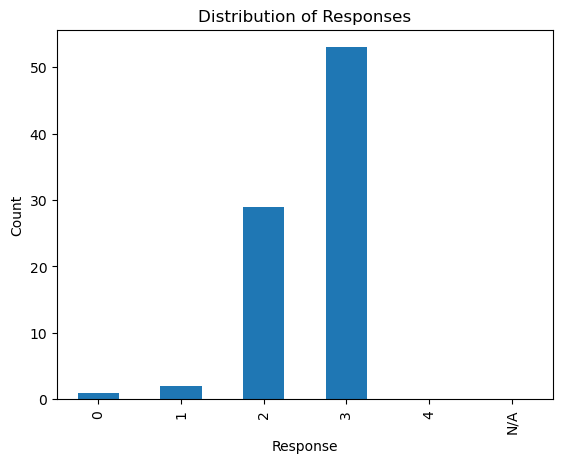

In [ ]:

df["response"].value_counts().reindex(["0", "1", "2", "3", "4", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [ ]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.58
Standard deviation of scores: 0.61


In [ ]:
is_there_a_good_market(df)

Percentage of positive responses (3-4): 62.35%
Percentage of neutral responses (3): 34.12%
Percentage of negative responses (0-1): 3.53%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.58
Standard deviation of responses: 0.61
VERDICT: There is a good market for bottled gazpacho.


True

## Benchmark: Spain
Naturally, we'll want to compare the results of our market research with the results in Spain, home of Gazpacho.

In [ ]:
factory_es = TinyPersonFactory.create_factory_from_demography("./information/populations/spain.json", 
                                                              population_size=population_size,
                                                              additional_demographic_specification=additional_demographic_specification)

people_es = factory_es.generate_people(population_size, verbose=True)
control.checkpoint()

market_es = TinyWorld(f"Target audience (Spanish)", people_es, broadcast_if_no_target=False)
market_es.broadcast(interviewer_introduction)
market_es.broadcast(interviewer_main_question)
market_es.broadcast_thought(inner_monologue)
market_es.run(1)
control.checkpoint()

2025-07-15 17:13:22,316 - tinytroupe - ERROR - Error occurred while extracting JSON: Expecting ',' delimiter: line 1 column 9521 (char 9520). Input text: {"sampling_space_description": "A detailed overview of the population demographics, traits, and habits of Spain, including various segments and characteristics.", "dimensions": [ {"name": "age", "range": [0, 100]}, {"name": "gender", "values": ["Male", "Female", "Non-binary", "Genderqueer", "Transgender"]}, {"name": "racial_and_ethnic_composition", "values": {"Spanish (Native)": 0.84, "Other European": 0.03, "Moroccan/North African": 0.029, "Latin American": 0.059, "Sub-Saharan African": 0.012, "Asian": 0.012, "Other": 0.018}}, {"name": "educational_attainment", "values": ["No formal education", "Primary education", "Secondary education", "Upper Secondary Education", "Tertiary Education (University Degree)", "Postgraduate Education"]}, {"name": "household_income", "values": {"Under €10,000": 0.14, "€10,000-€19,999": 0.24, "€20,000-€34

Generated person 8/100: Kiyomi Tanaka-Smithson is a 63 year old Artist and Art Educator, Japanese-American, currently living in San Francisco, California, USA. Kiyomi Tanaka-Smithson embodies a warm and nurturing spirit, often using her gentle sense of humor to create an inviting atmosphere in her workshops. Her deep empathy and connection to her cultural heritage inspire her to encourage others to explore their creativity, regardless of their background. Outside of her artistic pursuits, Kiyomi enjoys quiet afternoons tending to her garden, where she finds solace and inspiration in nature. With a passion for art history and cultural studies, she actively engages in community events, believing that art can foster social change and promote understanding among diverse groups.
Generated person 11/100: Santiago Javier Torres-Smithson is a 26 year old Marketing Specialist, Spanish, currently living in Madrid, Spain. Santiago is an enthusiastic and optimistic individual, often using humor to

2025-07-15 17:20:18,977 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
ERROR:tinytroupe:Could not generate an agent after 10 attempts.
2025-07-15 17:20:18,982 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
ERROR:tinytroupe:Name None was not used, it will be added back to the pool of names.
2025-07-15 17:20:18,984 - tinytroupe - ERROR - Could not generate person 50/100. Continuing with the remaining ones.
ERROR:tinytroupe:Could not generate person 50/100. Continuing with the remaining ones.


Generated person 58/100: Person_43_unknown is a 63 year old Retired, American, currently living in Phoenix, Arizona. Person_43_unknown is a thoughtful individual who values the simple pleasures in life, such as quiet mornings with a good book and leisurely walks in nature. His strong negotiation skills and experience in sales management have made him a natural mentor, often sharing valuable life lessons with younger family members. While he enjoys reminiscing about his past, he also embraces lifelong learning, frequently engaging in online courses to enhance his financial management skills. With a passion for gardening and a love for classic rock music, he finds joy in nurturing both his plants and his relationships, particularly with his wife Linda and granddaughter Sarah.
Generated person 53/100: Person_47_unknown is a 63 year old Retired, American, currently living in Phoenix, Arizona. Person_47_unknown is a friendly and approachable individual who thrives on social interactions, of

2025-07-15 17:20:53,263 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
ERROR:tinytroupe:Could not generate an agent after 10 attempts.
2025-07-15 17:20:53,272 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
ERROR:tinytroupe:Name None was not used, it will be added back to the pool of names.
2025-07-15 17:20:53,282 - tinytroupe - ERROR - Could not generate person 63/100. Continuing with the remaining ones.
ERROR:tinytroupe:Could not generate person 63/100. Continuing with the remaining ones.
2025-07-15 17:20:53,320 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
ERROR:tinytroupe:Could not generate an agent after 10 attempts.
2025-07-15 17:20:53,322 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
ERROR:tinytroupe:Name None was not used, it will be added back to the pool of names.
2025-07-15 17:20:53,325 - tinytroupe - ERROR - Could not generate person 73/100.

Generated person 57/100: Cecilia Margaret Whitaker-Smithson is a 55 year old Artist and Art Therapist, British, currently living in Bristol, England. Cecilia is a deeply empathetic individual, often finding solace in nature and using it as a source of inspiration for her art. Her whimsical sense of humor helps her connect with others, making her art therapy sessions both engaging and nurturing. While she excels in various artistic mediums, her perfectionist tendencies can sometimes hinder her creative flow, leading her to second-guess her choices. Outside of her professional life, she enjoys quiet moments spent gardening or sharing homemade meals with friends, reflecting her belief that community and connection are essential for personal growth.


ERROR:tinytroupe:Could not generate an agent after 10 attempts.
2025-07-15 17:20:53,456 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
ERROR:tinytroupe:Name None was not used, it will be added back to the pool of names.
2025-07-15 17:20:53,457 - tinytroupe - ERROR - Could not generate person 78/100. Continuing with the remaining ones.
ERROR:tinytroupe:Could not generate person 78/100. Continuing with the remaining ones.
2025-07-15 17:20:53,478 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
ERROR:tinytroupe:Could not generate an agent after 10 attempts.
2025-07-15 17:20:53,479 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
ERROR:tinytroupe:Name None was not used, it will be added back to the pool of names.
2025-07-15 17:20:53,481 - tinytroupe - ERROR - Could not generate person 79/100. Continuing with the remaining ones.
ERROR:tinytroupe:Could not generate person 79/100. Contin

Generated person 65/100: Mateo Alejandro Vargas-Salinas is a 26 year old Aspiring Entrepreneur, Chilean, currently living in Santiago, Chile. Mateo Alejandro Vargas-Salinas is not only driven by his entrepreneurial ambitions but also possesses a deep sense of empathy and justice, which fuels his passion for social entrepreneurship. He thrives in vibrant environments, often found in bustling coffee shops or networking events where he can connect with like-minded individuals. Despite his occasional self-doubt, Mateo's resilience shines through as he embraces failure as a learning opportunity, constantly seeking feedback to refine his ideas. His active lifestyle and love for outdoor activities reflect his belief in maintaining a balanced life while pursuing his long-term goals of financial independence and contributing to sustainable business practices in Latin America.
Generated person 70/100: Person_32_unknown is a 26 year old Digital Marketing Specialist, American, currently living in 

USER --> Kiyomi Tanaka-Smithson: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Santiago Javier Torres-Smithson

       + --> Mateo Alejandro Torres-Ramirez

       + --> ...others...

USER --> Kiyomi Tanaka-Smithson: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 0 to 4), where:        - 0: would
          > NEVER buy it        - 1: very unlikely, but not impossible        - 2: maybe I would buy
          > it, not sure        - 3: it is very likely        - 4: would CERTAINLY buy it

       + --> Santiago Javier Torres-Smithson

       + --> Mateo Alejandro Torres-Ramirez

       + --> ...others...

Kiyomi Tanaka-Smithson --> Kiyomi Tanaka-Smithson: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.

Santiago Javier Torres-Smithson --> Santiago Javier Torres-Smithson: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Mateo Alejandro Torres-Ramirez --> Mateo Alejandro Torres-Ramirez: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Person_99_unknown --> Person_99_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_94_unknown --> Person_94_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_98_unknown --> Person_98_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Hiroshi Takahashi-Rivera --> Hiroshi Takahashi-Rivera: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.

Kiyoshi Haruto Yamamoto --> Kiyoshi Haruto Yamamoto: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Juliana Mei Tanaka-Rivera --> Juliana Mei Tanaka-Rivera: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests.      Now I **must**
                               > first THINK deeply about the question, consider all the factors
                               > that might influence my decision,     and only then I will TALK
                               > with my response to the question as best, as detailed and as
                               > honestly as I can.

Juliana Mae Carter-Smithson --> Juliana Mae Carter-Smithson: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Person_93_unknown --> Person_93_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_90_unknown --> Person_90_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Evelyn Juniper Carter-Smithson --> Evelyn Juniper Carter-Smithson: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Elena Sofia Ramirez-Salinas --> Elena Sofia Ramirez-Salinas: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Gabriela Elena Torres-Morales --> Gabriela Elena Torres-Morales: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Gabriel Alejandro Mendoza-Smith --> Gabriel Alejandro Mendoza-Smith: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Gabriela Elena Torres-Salinas --> Gabriela Elena Torres-Salinas: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Diego Alejandro Torres-Salinas --> Diego Alejandro Torres-Salinas: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Person_85_unknown --> Person_85_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Juliana Mei Tanaka --> Juliana Mei Tanaka: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.

Aaliyah Juniper Thompson-Smith --> Aaliyah Juniper Thompson-Smith: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Lian Mei Chen-Rivera --> Lian Mei Chen-Rivera: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.

Emilia Valentina Torres-Salinas --> Emilia Valentina Torres-Salinas: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Juliana Sofia Ramirez-Salinas --> Juliana Sofia Ramirez-Salinas: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Cecilia Valentina Torres-Ramirez --> Cecilia Valentina Torres-Ramirez: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests.      Now I **must** first THINK deeply about
                                      > the question, consider all the factors that might influence
                                      > my decision,     and only then I will TALK with my response
                                      > to the question as best, as detailed and as honestly as I
                                      > can.

Juliana Mae Carter-Salinas --> Juliana Mae Carter-Salinas: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests.      Now I
                                > **must** first THINK deeply about the question, consider all the
                                > factors that might influence my decision,     and only then I will
                                > TALK with my response to the question as best, as detailed and as
                                > honestly as I can.

Person_72_unknown --> Person_72_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Juliana Estelle Ramirez-Smithson --> Juliana Estelle Ramirez-Smithson: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests.      Now I **must** first THINK deeply about
                                      > the question, consider all the factors that might influence
                                      > my decision,     and only then I will TALK with my response
                                      > to the question as best, as detailed and as honestly as I
                                      > can.

Mateo Alejandro Torres-Salinas --> Mateo Alejandro Torres-Salinas: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Alberto Javier Mendoza-Ramirez --> Alberto Javier Mendoza-Ramirez: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Jin Wei Chen-Smithson --> Jin Wei Chen-Smithson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Emilia Valentina Torres-Smithson --> Emilia Valentina Torres-Smithson: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests.      Now I **must** first THINK deeply about
                                      > the question, consider all the factors that might influence
                                      > my decision,     and only then I will TALK with my response
                                      > to the question as best, as detailed and as honestly as I
                                      > can.

Kiyoshi Tanaka-Smithson --> Kiyoshi Tanaka-Smithson: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Santiago Javier Ortega-Ramirez --> Santiago Javier Ortega-Ramirez: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Hiroshi Takahashi-Jones --> Hiroshi Takahashi-Jones: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Claudia Isabel Torres-Morales --> Claudia Isabel Torres-Morales: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Person_59_unknown --> Person_59_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Elena Sofia Ramirez-Castillo --> Elena Sofia Ramirez-Castillo: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Jasmine Alondra Reyes-Smith --> Jasmine Alondra Reyes-Smith: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Person_57_unknown --> Person_57_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Santiago Javier Morales-Ramirez --> Santiago Javier Morales-Ramirez: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Cecilia Valentina Torres-Smithson --> Cecilia Valentina Torres-Smithson: [THOUGHT] 
                                       >      I will be honest as I understand they are not here to
                                       > judge me, but just to learn from me.      Such choices
                                       > depend on many factors, but I will make my best guess,
                                       > considering my current      situation in life, location,
                                       > job and interests.      Now I **must** first THINK deeply
                                       > about the question, consider all the factors that might
                                       > influence my decision,     and only then I will TALK with
                                       > my response to the question as best, as detailed and as
                                       > honestly as I can.

Diego Alejandro Vargas-Salinas --> Diego Alejandro Vargas-Salinas: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Person_52_unknown --> Person_52_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Emilia Sofia Torres-Ramirez --> Emilia Sofia Torres-Ramirez: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Carmen Valentina Reyes-Salinas --> Carmen Valentina Reyes-Salinas: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Elena Sofia Whitaker-Smithson --> Elena Sofia Whitaker-Smithson: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Lia Chen-Smithson --> Lia Chen-Smithson: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_43_unknown --> Person_43_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_47_unknown --> Person_47_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_51_unknown --> Person_51_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_48_unknown --> Person_48_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Gabriela Elena Torres-Smith --> Gabriela Elena Torres-Smith: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Jasmine Alondra Rivera-Smith --> Jasmine Alondra Rivera-Smith: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Kaito Haruki Yamamoto --> Kaito Haruki Yamamoto: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.

Avery Juniper Carter-Smithson --> Avery Juniper Carter-Smithson: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests.
                                   > Now I **must** first THINK deeply about the question, consider
                                   > all the factors that might influence my decision,     and only
                                   > then I will TALK with my response to the question as best, as
                                   > detailed and as honestly as I can.

Person_42_unknown --> Person_42_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Elena Sofia Ramirez-Smithson --> Elena Sofia Ramirez-Smithson: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests.      Now I
                                  > **must** first THINK deeply about the question, consider all the
                                  > factors that might influence my decision,     and only then I
                                  > will TALK with my response to the question as best, as detailed
                                  > and as honestly as I can.

Cecilia Margaret Whitaker-Smithson --> Cecilia Margaret Whitaker-Smithson: [THOUGHT] 
                                        >      I will be honest as I understand they are not here to
                                        > judge me, but just to learn from me.      Such choices
                                        > depend on many factors, but I will make my best guess,
                                        > considering my current      situation in life, location,
                                        > job and interests.      Now I **must** first THINK deeply
                                        > about the question, consider all the factors that might
                                        > influence my decision,     and only then I will TALK with
                                        > my response to the question as best, as detailed and as
                                        > honestly as I can.

Mateo Alejandro Vargas-Salinas --> Mateo Alejandro Vargas-Salinas: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Person_32_unknown --> Person_32_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Person_29_unknown --> Person_29_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Carmen Valentina Reyes-Morales --> Carmen Valentina Reyes-Morales: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests.
                                    > Now I **must** first THINK deeply about the question, consider
                                    > all the factors that might influence my decision,     and only
                                    > then I will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Person_34_unknown --> Person_34_unknown: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.

Kaito Yamamoto-Smithson --> Kaito Yamamoto-Smithson: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.

Juliana Estelle Carter-Smithson --> Juliana Estelle Carter-Smithson: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Cecilia Margaret Whitaker-Smith --> Cecilia Margaret Whitaker-Smith: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests.      Now I **must** first THINK deeply about the
                                     > question, consider all the factors that might influence my
                                     > decision,     and only then I will TALK with my response to
                                     > the question as best, as detailed and as honestly as I can.

Julián Mateo Torres-Ramírez --> Julián Mateo Torres-Ramírez: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

Elena Sofia Martinez-Rivera --> Elena Sofia Martinez-Rivera: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.

────────────────────────────────────── Target audience (Spanish) step 1 of 1 ──────────────────────────────────────

Person_94_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                       > especially healthy options, and I appreciate convenience in my busy life as
                       > a sales representative. However, I also have to think about the quality and
                       > taste of the product. Given that I like cooking and trying new recipes, I
                       > might be inclined to buy it if it tastes good and is made with fresh
                       > ingredients. I should also consider how often I shop at supermarkets and
                       > whether this product would fit into my regular grocery list.

Person_93_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy fresh, healthy foods,
                       > and I appreciate the convenience of ready-made options. However, I also
                       > value quality and taste, so I would need to ensure that the product meets
                       > my standards. Additionally, I should think about how often I would actually
                       > buy it and if it fits into my routine. Given my love for cooking and
                       > preparing meals, I might not rely on store-bought options as much, but I
                       > could see myself purchasing it occasionally, especially during hot weather
                       > or when I'm busy. Overall, I think I would rate my propensity to purchase
                       > it as a 2, indicating that I might buy it but I'm not entirely sure.

Kiyoshi Haruto Yamamoto acts: [THINK] 
                             > I need to consider my personal preferences and lifestyle when it
                             > comes to purchasing ready-to-drink bottled gazpacho. I enjoy trying
                             > new foods, especially those that are healthy and refreshing. However,
                             > I also have to think about the availability of fresh ingredients and
                             > whether I would prefer making it myself. Given my busy work schedule,
                             > convenience is a factor, but I also value quality. I should rate my
                             > propensity to purchase it based on these considerations.

Person_90_unknown acts: [THINK] 
                       > I need to consider my feelings about gazpacho. I enjoy fresh vegetables and
                       > appreciate healthy options, but I also have to think about convenience and
                       > taste. Ready-to-drink options can be appealing if they maintain the quality
                       > of homemade versions. I should also reflect on how often I would actually
                       > purchase it and if it fits into my lifestyle. Given my love for cooking, I
                       > might prefer making it myself, but I can see the appeal of a convenient
                       > option. Overall, I think I would be open to trying it, especially if it's
                       > well-made and available locally.

Person_99_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                       > especially those that are healthy and refreshing. However, I also tend to
                       > be cautious about convenience products, as I prefer cooking at home. I
                       > should weigh the convenience of having a ready-to-drink option against my
                       > usual habits of preparing meals myself. Additionally, I should think about
                       > the quality and taste of the product, as well as its price point. Overall,
                       > I feel that I might be open to trying it, but I need to assess how much I
                       > would actually buy it regularly.

Juliana Mae Carter-Smithson acts: [TALK] 
                                 > I appreciate the opportunity to share about myself! My name is
                                 > Juliana Mae Carter-Smithson, and I'm a 32-year-old marketing
                                 > specialist based in Austin, Texas. I have a Bachelor's degree in
                                 > Business Administration with a specialization in Marketing from
                                 > the University of Texas at Austin. My top-10 interests include:
                                 > 1. Digital marketing trends, 2. Entrepreneurship, 3. Yoga and
                                 > wellness, 4. Traveling to new places, 5. Cooking and trying new
                                 > recipes, 6. Outdoor activities like hiking and biking, 7. Art and
                                 > culture, especially local exhibitions, 8. Networking events that
                                 > foster collaboration, 9. Podcasts about business and personal
                                 > development, and 10. Volunteering at local non-profits focused on
                                 > women's empowerment.

Person_98_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                       > especially those that are healthy and refreshing. Gazpacho sounds
                       > appealing, especially during the warmer months. However, I also need to
                       > think about the convenience of purchasing it and whether it fits into my
                       > budget. I should also consider if I have had similar products before and
                       > how I felt about them. Overall, I think I would be open to trying it, but I
                       > need to weigh these factors carefully before making a decision.

Santiago Javier Torres-Smithson acts: [THINK] 
                                     > I need to consider my personal preferences and lifestyle when
                                     > it comes to purchasing ready-to-drink bottled gazpacho. I
                                     > enjoy healthy and convenient food options, and gazpacho
                                     > aligns with my interest in Spanish cuisine. However, I also
                                     > need to think about the quality and taste of the product, as
                                     > well as its availability in local supermarkets. Given that I
                                     > often look for quick meal solutions, I might be inclined to
                                     > try it if it’s well-reviewed and easily accessible.

Juliana Mei Tanaka-Rivera acts: [TALK] 
                               > I appreciate the opportunity to share about myself! My name is
                               > Juliana Mei Tanaka-Rivera, and I'm 26 years old. I work as an
                               > Environmental Consultant at EcoSolutions Ltd., where I help
                               > businesses implement sustainable practices. My top-10 interests
                               > include: 1. Environmental activism, 2. Traveling, 3. Photography,
                               > 4. Cooking, 5. Yoga, 6. Community engagement, 7. Urban
                               > sustainability, 8. Nature conservation, 9. Learning about different
                               > cultures, and 10. Participating in local clean-up events.

Kiyomi Tanaka-Smithson acts: [TALK] 
                            > I appreciate the opportunity to share my thoughts. My name is Kiyomi
                            > Tanaka-Smithson, and I am a freelance artist and art educator based in
                            > San Francisco. My top interests include art history, cultural studies,
                            > gardening, cooking traditional Japanese dishes, traveling to art
                            > exhibitions, and spending time with family and friends. Regarding the
                            > gazpacho, I would rate my propensity to purchase ready-to-drink
                            > bottled gazpacho as a 2. I think it could be a refreshing option,
                            > especially in warmer months, but I would need to consider the quality
                            > and ingredients before making a decision.

Person_90_unknown acts: [TALK] 
                       > I appreciate the idea of offering ready-to-drink bottled gazpacho in
                       > supermarkets. I enjoy fresh vegetables and healthy options, so I would be
                       > open to trying it. However, I also love cooking and making my own meals,
                       > which might influence how often I would purchase it. If the quality is good
                       > and it tastes fresh, I would rate my propensity to buy it as a 2, meaning
                       > maybe I would buy it, but I'm not entirely sure yet.

Person_90_unknown acts: [DONE] 

Person_94_unknown acts: [TALK] 
                       > Considering my current situation and preferences, I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is very
                       > likely. I enjoy healthy options and appreciate convenience, so if it tastes
                       > good and is made with quality ingredients, I would definitely consider
                       > buying it.

Person_98_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is very
                       > likely. I enjoy trying new foods, especially refreshing options during the
                       > warmer months, and gazpacho sounds appealing. However, I would need to
                       > consider factors like convenience and budget before making a final
                       > decision.

Person_99_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. I think it
                       > could be a refreshing option, especially during hot weather, but I am not
                       > entirely sure if I would buy it regularly. It would depend on factors like
                       > taste, price, and whether it fits into my cooking habits.

Person_93_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. While I
                       > enjoy fresh and healthy foods, I also value quality and taste. I might
                       > consider buying it occasionally, especially during hot weather or when I'm
                       > busy, but I generally prefer preparing my meals myself. Thank you for
                       > asking!

Juliana Mae Carter-Smithson acts: [TALK] 
                                 > Regarding the gazpacho, I would rate my propensity to purchase
                                 > ready-to-drink bottled gazpacho as a 3. It is very likely that I
                                 > would buy it, especially if it is made with fresh ingredients and
                                 > has a good flavor profile. I enjoy trying new products,
                                 > particularly those that align with my interest in healthy eating
                                 > and cooking. However, factors like price and availability would
                                 > also play a significant role in my decision.

Mateo Alejandro Torres-Ramirez acts: [TALK] 
                                    > Thank you for the opportunity to introduce myself. My name is
                                    > Mateo Alejandro Torres-Ramirez, I'm 32 years old, and I work
                                    > as a Financial Analyst at Grupo Financiero Banorte. Here are
                                    > my top interests: 1. Finance and investment strategies, 2.
                                    > Local cuisine and cooking, 3. Traveling to historical sites,
                                    > 4. Reading about economics and market trends, 5. Playing chess
                                    > with friends.

Kiyoshi Haruto Yamamoto acts: [TALK] 
                             > Considering my current lifestyle and preferences, I would rate my
                             > propensity to purchase ready-to-drink bottled gazpacho as a 2. I
                             > think it could be a refreshing option, especially during the warmer
                             > months, but I am not entirely sure if I would choose it over other
                             > options or making it myself. It really depends on the quality and
                             > taste of the product available in the supermarket.

Santiago Javier Torres-Smithson acts: [TALK] 
                                     > I appreciate the opportunity to share my thoughts! I would
                                     > rate my propensity to purchase ready-to-drink bottled
                                     > gazpacho as a 3. It is very likely that I would buy it,
                                     > especially if it’s convenient and tastes good. I enjoy
                                     > healthy options, and gazpacho fits well with my lifestyle.
                                     > However, I would need to see how it compares to homemade
                                     > versions in terms of flavor and quality.

Kiyomi Tanaka-Smithson acts: [DONE] 

Person_98_unknown acts: [DONE] 

Person_94_unknown acts: [DONE] 

Juliana Mei Tanaka-Rivera acts: [TALK] 
                               > Regarding the gazpacho, I would rate my propensity to purchase
                               > ready-to-drink bottled gazpacho as a 3. It is very likely that I
                               > would buy it, especially if it aligns with my values of
                               > sustainability and healthy eating. I enjoy fresh, healthy foods,
                               > and if the product is made with quality ingredients and promotes
                               > environmental responsibility, I would definitely consider it.

Person_99_unknown acts: [DONE] 

Person_93_unknown acts: [DONE] 

Juliana Mae Carter-Smithson acts: [DONE] 

Kiyoshi Haruto Yamamoto acts: [DONE] 

Santiago Javier Torres-Smithson acts: [DONE] 

Evelyn Juniper Carter-Smithson acts: [TALK] 
                                    > I appreciate the opportunity to share my thoughts. My name is
                                    > Evelyn Juniper Carter-Smithson, and I am an urban planner
                                    > focused on sustainable development. My top interests include
                                    > sustainable architecture, community gardening, environmental
                                    > activism, traveling to national parks, reading about climate
                                    > change solutions, freshly brewed coffee in the morning, nature
                                    > walks and hiking, attending local farmers' markets,
                                    > participating in community clean-up events, and listening to
                                    > podcasts about urban development.   Regarding the ready-to-
                                    > drink bottled gazpacho, I think it could be a refreshing
                                    > option, especially during warmer months. I would rate my
                                    > propensity to purchase it as a 3: it is very likely. I enjoy
                                    > healthy and convenient food options, and if it aligns with my
                                    > values of sustainability and health, I would certainly
                                    > consider buying it.

Juliana Mei Tanaka-Rivera acts: [DONE] 

Mateo Alejandro Torres-Ramirez acts: [TALK] 
                                    > Regarding the gazpacho, I appreciate the idea of having ready-
                                    > to-drink bottled gazpacho available at my local supermarket. I
                                    > enjoy trying new food products, especially those that reflect
                                    > local or international cuisine. Considering my current
                                    > lifestyle and preferences, I would rate my propensity to
                                    > purchase it as a 3: it is very likely that I would buy it if
                                    > it were available.

Elena Sofia Ramirez-Salinas acts: [THINK] 
                                 > I need to consider my personal preferences and lifestyle when it
                                 > comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                 > healthy, fresh foods, and gazpacho aligns with my interest in
                                 > sustainable and nutritious options. However, I also think about
                                 > the convenience factor and whether it would fit into my busy
                                 > schedule as an entrepreneur. I should also consider the quality
                                 > of the product and if it uses organic ingredients, which is
                                 > important to me. Overall, I feel positive about the idea, but I
                                 > need to rate my likelihood of purchasing it based on these
                                 > factors.

Mateo Alejandro Torres-Ramirez acts: [DONE] 

Hiroshi Takahashi-Rivera acts: [THINK] 
                              > I need to consider my personal preferences and lifestyle when it
                              > comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                              > culinary experiences, especially those that are innovative yet
                              > respect tradition. Gazpacho is a refreshing option, especially in
                              > the hot summer months, and aligns with my interest in healthy
                              > eating. However, I also value fresh, homemade meals, which might
                              > make me hesitant to buy a pre-packaged product. I should also think
                              > about the availability of fresh ingredients and whether I would
                              > prefer to make it myself. Overall, I will rate my propensity to
                              > purchase it based on these considerations.

Gabriela Elena Torres-Morales acts: [THINK] 
                                   > I need to consider my personal preferences and lifestyle when
                                   > it comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                   > healthy and convenient food options, and gazpacho aligns with
                                   > my interest in cooking and trying new recipes. However, I also
                                   > need to think about the quality of the product and whether it
                                   > would be as good as homemade. Given my busy schedule as a
                                   > freelance business consultant, I might appreciate the
                                   > convenience of having it available at the supermarket. Overall,
                                   > I think I would be open to trying it, but I need to evaluate
                                   > the brand and ingredients first.

Gabriela Elena Torres-Salinas acts: [THINK] 
                                   > I need to consider my personal preferences and lifestyle when
                                   > it comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                   > cooking traditional dishes, and while I appreciate convenience,
                                   > I also value fresh ingredients. I should think about how often
                                   > I would actually buy it, whether it fits into my diet, and if I
                                   > would prefer making it myself instead. Given that I live in
                                   > Mexico City, I might have access to fresh ingredients for
                                   > making gazpacho at home, but the convenience of a ready-to-
                                   > drink option could be appealing for busy days. Overall, I think
                                   > I would rate my propensity to purchase it as a 2, since I'm not
                                   > sure if I would buy it regularly, but it's a possibility.

Juliana Mei Tanaka acts: [THINK] 
                        > I need to consider my personal preferences and lifestyle when it comes to
                        > purchasing ready-to-drink bottled gazpacho. I enjoy healthy and refreshing
                        > foods, especially during the hot months in São Paulo. Gazpacho sounds
                        > appealing as a quick meal option, especially since I often look for
                        > convenient yet nutritious choices. However, I also need to think about the
                        > price and availability in local supermarkets. Overall, I think I would be
                        > open to trying it, but I need to evaluate how often I would actually buy
                        > it.

Person_85_unknown acts: [THINK] 
                       > I need to consider my feelings about gazpacho. I enjoy fresh vegetables and
                       > appreciate healthy options, but I also have to think about convenience and
                       > taste. Ready-to-drink options can be appealing if they maintain the quality
                       > and flavor of homemade gazpacho. I should also reflect on how often I would
                       > actually purchase it and if it fits into my lifestyle. Overall, I think I
                       > would be open to trying it, especially if it’s available locally and made
                       > with quality ingredients.

Aaliyah Juniper Thompson-Smith acts: [TALK] 
                                    > Hello! I'm Aaliyah Juniper Thompson-Smith, a 26-year-old
                                    > marketing specialist based in Atlanta, Georgia. I work at
                                    > Creative Solutions Agency, where I focus on developing and
                                    > implementing digital marketing campaigns for small to medium-
                                    > sized businesses. My top 10 interests include: 1. Digital
                                    > marketing trends, 2. Traveling and exploring new cultures, 3.
                                    > Photography, 4. Cooking and trying new recipes, 5.
                                    > Volunteering for local charities, 6. Outdoor activities like
                                    > hiking and biking, 7. Art and music festivals, 8. Books on
                                    > personal development and marketing, 9. Coffee shops with a
                                    > cozy atmosphere, and 10. Spending time with friends and
                                    > family.

Elena Sofia Ramirez-Salinas acts: [TALK] 
                                 > I appreciate the idea of offering ready-to-drink bottled gazpacho
                                 > in supermarkets. I would rate my propensity to purchase it as a
                                 > 3, which means it is very likely that I would buy it. I enjoy
                                 > healthy and fresh foods, and gazpacho fits well with my
                                 > lifestyle. However, I would need to ensure that the product uses
                                 > high-quality, organic ingredients to align with my values.

Lian Mei Chen-Rivera acts: [TALK] 
                          > I appreciate the opportunity to share about myself. My name is Lian Mei
                          > Chen-Rivera, and I am an urban planner at Green City Solutions. I am
                          > passionate about sustainable living and community engagement. Here are
                          > my top-10 interests: 1. Sustainable living, 2. Community gardening, 3.
                          > Traveling to learn about different cultures, 4. Photography, especially
                          > nature and urban landscapes, 5. Volunteering for environmental causes,
                          > 6. Reading books on environmental science and social justice, 7. Cooking
                          > and experimenting with new recipes, 8. Attending art and music festivals
                          > that promote sustainability, 9. Nature walks and hiking in national
                          > parks, 10. Engaging in discussions about sustainability with friends and
                          > family.

Evelyn Juniper Carter-Smithson acts: [DONE] 

Emilia Valentina Torres-Salinas acts: [TALK] 
                                     > I appreciate the opportunity to share my thoughts. My name is
                                     > Emilia Valentina Torres-Salinas, and I am a civil engineer
                                     > specializing in sustainable urban development. My top
                                     > interests include sustainable architecture, urban planning,
                                     > traveling, cooking, and photography. Regarding the ready-to-
                                     > drink bottled gazpacho, I would rate my propensity to
                                     > purchase it as a 3: it is very likely. I enjoy gazpacho,
                                     > especially during the warmer months, and having a convenient
                                     > option available at the supermarket would definitely appeal
                                     > to me.

Elena Sofia Ramirez-Salinas acts: [DONE] 

Gabriel Alejandro Mendoza-Smith acts: [TALK] 
                                     > Hello, I'm Gabriel Mendoza-Smith, a 45-year-old real estate
                                     > investor in Los Angeles. I focus on buying and renovating
                                     > homes. Here are some of my interests: 1) Real estate trends,
                                     > 2) Home design, 3) Traveling to historical sites, 4) Cooking,
                                     > 5) Family time, 6) Documentaries, 7) National parks, 8)
                                     > Farmers' markets, 9) Community projects, and 10) Sustainable
                                     > real estate.

Gabriela Elena Torres-Morales acts: [TALK] 
                                   > I appreciate the opportunity to share my thoughts. I would rate
                                   > my propensity to purchase ready-to-drink bottled gazpacho as a
                                   > 3: it is very likely. I enjoy healthy options and the
                                   > convenience of having something ready to drink, especially if
                                   > it maintains good quality. However, I would need to check the
                                   > ingredients and brand before making a final decision.

Hiroshi Takahashi-Rivera acts: [TALK] 
                              > After considering my preferences and lifestyle, I would rate my
                              > propensity to purchase ready-to-drink bottled gazpacho as a 2. I
                              > think I might buy it, but I'm not entirely sure. It sounds like a
                              > refreshing option, especially during the summer, but I also enjoy
                              > making my own meals with fresh ingredients. If it were available at
                              > my local supermarket, I would be open to trying it, but I would need
                              > to see how it compares to homemade versions.

Gabriela Elena Torres-Salinas acts: [TALK] 
                                   > I appreciate the idea of offering ready-to-drink bottled
                                   > gazpacho in supermarkets. However, I would rate my propensity
                                   > to purchase it as a 2. While I might consider buying it
                                   > occasionally, I am not entirely sure if I would do so
                                   > regularly, as I enjoy making traditional dishes myself and
                                   > value fresh ingredients.

Juliana Mei Tanaka acts: [TALK] 
                        > I appreciate the opportunity to share my thoughts! I would rate my
                        > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is very
                        > likely that I would buy it, especially if it is available at my local
                        > supermarket and priced reasonably. I enjoy healthy and refreshing foods,
                        > and gazpacho sounds like a great option for a quick meal, particularly
                        > during the warmer months. However, I would need to see how it fits into my
                        > budget and lifestyle before making a final decision.

Person_85_unknown acts: [TALK] 
                       > I appreciate the idea of offering ready-to-drink bottled gazpacho,
                       > especially since I enjoy fresh vegetables and healthy options. I would rate
                       > my propensity to purchase it as a 3: it is very likely. If it’s made with
                       > quality ingredients and available at my local supermarket, I would
                       > certainly consider buying it.

Juliana Mei Tanaka acts: [DONE] 

Person_85_unknown acts: [DONE] 

Gabriela Elena Torres-Salinas acts: [DONE] 

Hiroshi Takahashi-Rivera acts: [DONE] 

Gabriela Elena Torres-Morales acts: [DONE] 

Diego Alejandro Torres-Salinas acts: [TALK] 
                                    > I appreciate the opportunity to share about myself. My name is
                                    > Diego Alejandro Torres-Salinas, I'm 32 years old, and I work
                                    > as a Financial Analyst at Grupo Financiero Colpatria. My top
                                    > interests include: 1. Investing and financial markets, 2.
                                    > Traveling and exploring new cultures, 3. Reading about
                                    > economics and personal finance, 4. Playing soccer with
                                    > friends, 5. Cooking and experimenting with new recipes, 6.
                                    > Outdoor activities like hiking and biking, 7. Watching
                                    > documentaries about economic history, 8. Spending time with
                                    > family and friends, 9. Engaging in discussions about current
                                    > economic events, and 10. Enjoying coffee from local roasters.

Cecilia Valentina Torres-Ramirez acts: [TALK] 
                                      > Hello, I'm Cecilia Valentina Torres-Ramirez, a 45-year-old
                                      > business consultant based in Mexico City. I specialize in
                                      > helping small to medium-sized enterprises improve their
                                      > operations and marketing strategies. My top-10 interests
                                      > include: 1. Entrepreneurship, 2. Traveling, 3. Cooking, 4.
                                      > Reading business literature, 5. Volunteering for women's
                                      > rights organizations, 6. Networking events and conferences,
                                      > 7. Documentaries about successful entrepreneurs, 8. Outdoor
                                      > activities like hiking, 9. Spicy food, especially
                                      > traditional Mexican dishes, and 10. Coffee shops with a cozy
                                      > atmosphere.

Juliana Sofia Ramirez-Salinas acts: [THINK] 
                                   > I need to consider my feelings about gazpacho and how it fits
                                   > into my lifestyle. I enjoy fresh, organic food, and I
                                   > appreciate convenience, especially with my busy work schedule.
                                   > Gazpacho sounds refreshing and healthy, which aligns with my
                                   > interests in sustainable living and cooking. However, I also
                                   > think about the quality of the product and whether it would be
                                   > made with organic ingredients. I should rate my propensity to
                                   > purchase it based on these factors.

Emilia Valentina Torres-Salinas acts: [DONE] 

Gabriel Alejandro Mendoza-Smith acts: [TALK] 
                                     > Regarding the gazpacho, I think it's an interesting idea. I
                                     > enjoy trying new foods, especially healthy options. I would
                                     > rate my propensity to purchase ready-to-drink bottled
                                     > gazpacho as a 3: it is very likely. If it's convenient and
                                     > tastes good, I would definitely consider buying it.

Lian Mei Chen-Rivera acts: [TALK] 
                          > Regarding the ready-to-drink bottled gazpacho, I would rate my
                          > propensity to purchase it as a 3: it is very likely. I enjoy fresh,
                          > healthy foods, and gazpacho aligns with my interest in sustainable
                          > living and organic ingredients. If it were available at my local
                          > supermarket, I would definitely consider buying it, especially if it
                          > emphasizes local produce and sustainability in its packaging and
                          > sourcing.

Juliana Mae Carter-Salinas acts: [THINK] 
                                > I need to consider my personal preferences and lifestyle when it
                                > comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                > fresh, healthy foods, and gazpacho aligns with my interest in
                                > vibrant flavors and cultural dishes. However, I also have to think
                                > about the convenience factor and whether I would choose it over
                                > making my own. Given my current financial situation, I might be
                                > cautious about spending on pre-packaged items unless they offer
                                > significant value or quality. Overall, I think I would be open to
                                > trying it, especially if it's available locally and marketed well.

Lian Mei Chen-Rivera acts: [DONE] 

Person_72_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy cooking and trying new
                       > recipes, but I also appreciate convenience. Gazpacho sounds refreshing,
                       > especially during the warmer months, and it aligns with my interest in
                       > healthy eating. However, I need to think about the availability of fresh
                       > ingredients and whether I would prefer making it myself or buying it. I
                       > should also consider how often I shop at the supermarket and if this
                       > product would fit into my regular purchases.

Aaliyah Juniper Thompson-Smith acts: [TALK] 
                                    > Regarding the gazpacho, I think it's a refreshing idea,
                                    > especially for the warmer months. I would rate my propensity
                                    > to purchase ready-to-drink bottled gazpacho as a 3: it is very
                                    > likely. I enjoy trying new products, especially those that
                                    > align with my interest in cooking and healthy eating. If it’s
                                    > available at my local supermarket, I would definitely consider
                                    > buying it!

Mateo Alejandro Torres-Salinas acts: [TALK] 
                                    > I appreciate the opportunity to share my thoughts. My name is
                                    > Mateo Alejandro Torres-Salinas, and I am a civil engineer
                                    > focused on sustainable building practices. My top interests
                                    > include sustainable architecture, urban planning, technology
                                    > in construction, traveling to historical sites, photography,
                                    > modern architecture and design, spending time in nature,
                                    > cooking traditional Spanish dishes, listening to classical
                                    > music while working, and engaging in discussions about
                                    > environmental issues.   Regarding the ready-to-drink bottled
                                    > gazpacho, I would rate my propensity to purchase it as a 3: it
                                    > is very likely. I enjoy gazpacho, especially during the warmer
                                    > months, and having a convenient option available at my local
                                    > supermarket would definitely appeal to me.

Alberto Javier Mendoza-Ramirez acts: [TALK] 
                                    > Hello, my name is Alberto Javier Mendoza-Ramirez. I am a
                                    > 45-year-old small business owner from Mexico City, where I run
                                    > Mendoza's Market, a grocery store that focuses on fresh
                                    > produce and local products. I am passionate about supporting
                                    > local farmers and providing healthy food options to my
                                    > community.   As for my top-10 interests, they include: 1)
                                    > Cooking traditional Mexican dishes, 2) Spending time with
                                    > family, 3) Watching soccer, especially Club América, 4)
                                    > Reading business books and articles, 5) Engaging in community
                                    > events, 6) Exploring local markets, 7) Listening to mariachi
                                    > music, 8) Gardening, 9) Learning about financial literacy, and
                                    > 10) Supporting local businesses.

Diego Alejandro Torres-Salinas acts: [TALK] 
                                    > Regarding the ready-to-drink bottled gazpacho, I would rate my
                                    > propensity to purchase it as a 3: it is very likely. I enjoy
                                    > trying new products, especially those that align with my
                                    > interests in healthy eating and cooking. If it’s convenient
                                    > and tastes good, I would definitely consider buying it.

Aaliyah Juniper Thompson-Smith acts: [DONE] 

Diego Alejandro Torres-Salinas acts: [DONE] 

Jin Wei Chen-Smithson acts: [TALK] 
                           > I appreciate the opportunity to share about myself. My name is Jin Wei
                           > Chen-Smithson, and I am a 26-year-old sustainability consultant based
                           > in San Francisco. I have a Bachelor's degree in Environmental Science
                           > from the University of California, Berkeley, where I focused on urban
                           > sustainability and green architecture. My top interests include
                           > sustainable architecture, urban gardening, traveling to eco-friendly
                           > destinations, volunteering for environmental causes, and photography,
                           > especially of nature and urban landscapes. I also enjoy fresh, organic
                           > food, nature walks, and community events focused on sustainability. I
                           > dislike wastefulness and consumerism, loud environments, and disregard
                           > for environmental issues.

Gabriel Alejandro Mendoza-Smith acts: [DONE] 

Cecilia Valentina Torres-Ramirez acts: [TALK] 
                                      > Regarding the gazpacho, I would rate my propensity to
                                      > purchase ready-to-drink bottled gazpacho as a 3: it is very
                                      > likely. I enjoy trying new products, especially those that
                                      > align with my interest in cooking and healthy eating. If
                                      > it’s convenient and tastes good, I would certainly consider
                                      > buying it.

Juliana Sofia Ramirez-Salinas acts: [TALK] 
                                   > I appreciate the idea of offering ready-to-drink bottled
                                   > gazpacho in supermarkets. I would rate my propensity to
                                   > purchase it as a 3, which means it is very likely that I would
                                   > buy it. I enjoy fresh, organic food, and if the gazpacho is
                                   > made with high-quality ingredients, it would definitely appeal
                                   > to me. Convenience is important in my busy life, and a healthy
                                   > option like gazpacho fits well with my interests in sustainable
                                   > living and cooking.

Emilia Valentina Torres-Smithson acts: [THINK] 
                                      > I need to consider my personal preferences and lifestyle
                                      > when it comes to purchasing ready-to-drink bottled gazpacho.
                                      > I enjoy fresh, organic food and appreciate convenience,
                                      > especially with my busy schedule as an urban planner.
                                      > Gazpacho aligns with my interest in healthy eating and
                                      > sustainability, as it is made from vegetables. However, I
                                      > also value quality and freshness, so I would need to ensure
                                      > that the product meets those standards. Given these factors,
                                      > I think I would be open to trying it, but I need to assess
                                      > how it fits into my routine and whether it is available at
                                      > local supermarkets.

Alberto Javier Mendoza-Ramirez acts: [TALK] 
                                    > Regarding the gazpacho, I think it's an interesting idea to
                                    > offer ready-to-drink bottled gazpacho in supermarkets. I enjoy
                                    > fresh and healthy options, and gazpacho fits that description
                                    > well. However, my decision to purchase it would depend on
                                    > factors like the price, quality, and whether it uses fresh
                                    > ingredients.   Considering these factors, I would rate my
                                    > propensity to purchase it as a 3: it is very likely that I
                                    > would buy it if it meets my expectations.

Juliana Sofia Ramirez-Salinas acts: [DONE] 

Mateo Alejandro Torres-Salinas acts: [DONE] 

Cecilia Valentina Torres-Ramirez acts: [DONE] 

Person_72_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is very
                       > likely that I would buy it, especially during the summer months when I'm
                       > looking for refreshing and healthy options. However, it would depend on the
                       > price and availability at my local supermarket.

Juliana Estelle Ramirez-Smithson acts: [THINK] 
                                      > I really enjoy fresh, healthy foods, and gazpacho is a
                                      > delightful option that aligns with my love for vibrant
                                      > flavors. However, I have a strong preference for homemade
                                      > meals, which makes me hesitant about purchasing pre-packaged
                                      > items. I appreciate the convenience of ready-to-drink
                                      > options, but I also value the experience of making my own
                                      > food. Given my current lifestyle and values, I would rate my
                                      > propensity to purchase bottled gazpacho as a 1. While it's
                                      > not impossible, I would likely prefer to make it myself or
                                      > seek out fresh versions at local markets.

Alberto Javier Mendoza-Ramirez acts: [DONE] 

Santiago Javier Ortega-Ramirez acts: [TALK] 
                                    > I appreciate the opportunity to share about myself. My name is
                                    > Santiago Javier Ortega-Ramirez, I'm 26 years old, and I'm an
                                    > entrepreneur based in Mexico City. I'm passionate about
                                    > sustainability and currently working on launching my own
                                    > startup focused on eco-friendly products. As for my top-10
                                    > interests, they include: 1. Sustainability, 2. Technology, 3.
                                    > Travel, 4. Social entrepreneurship, 5. Cooking, 6. Outdoor
                                    > activities like hiking and cycling, 7. Documentaries about
                                    > environmental issues, 8. Networking events and workshops, 9.
                                    > Innovative tech gadgets, and 10. Mexican cuisine, especially
                                    > street food.

Person_72_unknown acts: [DONE] 

Emilia Valentina Torres-Smithson acts: [TALK] 
                                      > Considering my preferences and lifestyle, I would rate my
                                      > propensity to purchase ready-to-drink bottled gazpacho as a
                                      > 3: it is very likely. I appreciate healthy, organic food,
                                      > and gazpacho aligns with my values. However, I would need to
                                      > ensure that the product is fresh and of high quality before
                                      > making a final decision.

Jin Wei Chen-Smithson acts: [TALK] 
                           > Regarding the idea of purchasing ready-to-drink bottled gazpacho, I
                           > would rate my propensity to buy it as a 2. I think it could be a
                           > refreshing option, especially during warmer months, but I would need to
                           > consider factors like the ingredients, price, and whether it aligns
                           > with my preference for fresh, organic food. If it meets those criteria,
                           > I might be inclined to try it.

Hiroshi Takahashi-Jones acts: [THINK] 
                             > I need to consider my personal preferences and lifestyle when it
                             > comes to purchasing ready-to-drink bottled gazpacho. I enjoy trying
                             > new foods, especially those that are healthy and align with my
                             > interest in cultural cuisines. However, I also value fresh
                             > ingredients and traditional preparation methods. I should weigh the
                             > convenience of a ready-to-drink option against my preference for
                             > homemade meals. Given my busy schedule as a business consultant, I
                             > might appreciate the convenience, but I also have to think about the
                             > quality of the product. Overall, I will rate my propensity to
                             > purchase it based on these considerations.

Emilia Valentina Torres-Smithson acts: [DONE] 

Juliana Mae Carter-Salinas acts: [TALK] 
                                > Thank you for asking! I would rate my propensity to purchase
                                > ready-to-drink bottled gazpacho as a 3. I love the idea of
                                > enjoying a refreshing, vibrant soup, especially during the hot
                                > Texas summers. Gazpacho's bright colors and fresh flavors resonate
                                > with my artistic sensibilities. However, I would definitely need
                                > to know more about the ingredients—if it's made with high-quality,
                                > fresh produce, that would make it even more appealing to me.
                                > Supporting local or organic brands would also be a big plus!

Claudia Isabel Torres-Morales acts: [THINK] 
                                   > I need to consider my personal preferences and lifestyle when
                                   > it comes to purchasing ready-to-drink bottled gazpacho. I enjoy
                                   > healthy eating and appreciate convenience, especially with my
                                   > busy schedule as a freelance business consultant. Gazpacho
                                   > aligns with my interest in traditional Mexican cuisine, and I
                                   > often look for quick meal options that are nutritious. However,
                                   > I also value fresh ingredients and homemade meals, which might
                                   > influence my decision. I will rate my propensity to purchase it
                                   > based on these factors.

Juliana Estelle Ramirez-Smithson acts: [TALK] 
                                      > I appreciate the idea of offering bottled gazpacho in
                                      > supermarkets, as it could provide a convenient option for
                                      > those who enjoy this refreshing soup. However, I must admit
                                      > that I have a strong preference for homemade meals, which
                                      > makes me hesitant about purchasing pre-packaged items. Given
                                      > my current lifestyle and values, I would rate my propensity
                                      > to purchase bottled gazpacho as a 1. While it's not
                                      > impossible, I would likely prefer to make it myself or seek
                                      > out fresh versions at local markets.

Jin Wei Chen-Smithson acts: [DONE] 

Person_59_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                       > especially healthy options, and I appreciate convenience in my busy life as
                       > a sales manager. However, I also value fresh ingredients and homemade
                       > meals. I should weigh these factors carefully before making a decision
                       > about how likely I would be to buy it.

Juliana Estelle Ramirez-Smithson acts: [DONE] 

Juliana Mae Carter-Salinas acts: [DONE] 

Person_57_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy fresh, organic food and
                       > appreciate convenience, especially when it aligns with my values of
                       > sustainability. However, I also have to think about the quality of the
                       > product and whether it meets my standards for healthy eating. Given that I
                       > often cook with fresh ingredients, I might be hesitant to buy a pre-made
                       > version unless it is truly high quality. I should also consider how often I
                       > would actually choose this over making my own soup or other meals.

Santiago Javier Ortega-Ramirez acts: [TALK] 
                                    > Regarding the ready-to-drink bottled gazpacho, I think it's a
                                    > refreshing idea, especially for the hot weather we often have
                                    > here in Mexico. I would rate my propensity to purchase it as a
                                    > 3: it is very likely. I enjoy trying new products, especially
                                    > those that align with my interest in healthy and sustainable
                                    > eating. If the ingredients are fresh and the product is
                                    > marketed well, I would definitely consider buying it.

Elena Sofia Ramirez-Castillo acts: [TALK] 
                                  > Hello! I'm Elena Sofia Ramirez-Castillo, a 30-year-old digital
                                  > marketing specialist based in Mexico City. I work as a
                                  > freelancer, helping small businesses enhance their online
                                  > presence through social media strategies and online advertising
                                  > campaigns. My top-10 interests include: 1. Digital marketing
                                  > trends, 2. Traveling, 3. Photography, 4. Cooking, 5.
                                  > Volunteering, 6. Exploring new cuisines, 7. Attending workshops,
                                  > 8. Spending time in nature, 9. Listening to entrepreneurship
                                  > podcasts, and 10. Reading personal development books.

Hiroshi Takahashi-Jones acts: [TALK] 
                             > Considering my lifestyle and preferences, I would rate my propensity
                             > to purchase ready-to-drink bottled gazpacho as a 2. I might buy it,
                             > but I'm not entirely sure. I appreciate the convenience of such
                             > products, especially given my busy schedule, but I also value fresh
                             > ingredients and traditional preparation methods. If the quality is
                             > high and it aligns with my taste for healthy options, I could see
                             > myself purchasing it occasionally.

Jasmine Alondra Reyes-Smith acts: [TALK] 
                                 > I appreciate the opportunity to share about myself! My name is
                                 > Jasmine Alondra Reyes-Smith, and I'm a 30-year-old marketing
                                 > specialist based in Los Angeles, California. I have a Bachelor's
                                 > degree in Business Administration with a focus on Marketing and
                                 > Consumer Behavior from UCLA. My top-10 interests include: 1.
                                 > Digital marketing, 2. Social media trends, 3. Traveling, 4.
                                 > Photography, 5. Cooking, 6. Fitness, 7. Attending marketing
                                 > conferences, 8. Exploring new restaurants, 9. Listening to
                                 > entrepreneurship podcasts, and 10. Practicing yoga and
                                 > mindfulness.

Kiyoshi Tanaka-Smithson acts: [TALK] 
                             > I appreciate the opportunity to share more about myself. My name is
                             > Kiyoshi Tanaka-Smithson, and I am a 37-year-old business consultant
                             > specializing in cross-cultural business strategies. I have a
                             > Bachelor's in Business Administration from Keio University and an MBA
                             > from the University of London. My top interests include: 1. Business
                             > strategy, 2. Cultural studies, 3. Travel, 4. Technology, 5. Cooking,
                             > 6. Reading business books and case studies, 7. Exploring new
                             > cultures, 8. Practicing calligraphy, 9. Attending cultural events,
                             > and 10. Networking with professionals.

Santiago Javier Morales-Ramirez acts: [TALK] 
                                     > Hello! I'm Santiago Javier Morales-Ramirez, a 32-year-old
                                     > entrepreneur from Mexico City. I'm currently working on
                                     > launching a tech startup focused on providing affordable
                                     > financial services to underserved communities. My top-10
                                     > interests include: 1. Technology and innovation, 2. Social
                                     > entrepreneurship, 3. Traveling to new places, 4. Cooking
                                     > traditional Mexican dishes, 5. Reading about personal
                                     > development, 6. Networking events and meetups, 7. Outdoor
                                     > activities like hiking and cycling, 8. Documentaries about
                                     > social issues, 9. Music festivals and live performances, 10.
                                     > Volunteering for local NGOs.

Santiago Javier Ortega-Ramirez acts: [DONE] 

Cecilia Valentina Torres-Smithson acts: [TALK] 
                                       > I appreciate the opportunity to share about myself. My name
                                       > is Cecilia Valentina Torres-Smithson, and I am an urban
                                       > planner focused on sustainable practices in urban
                                       > development. I have a Master's in Environmental Science
                                       > from Stanford University, and I work at Green City
                                       > Solutions. My top interests include sustainable living,
                                       > community gardening, traveling to eco-friendly
                                       > destinations, participating in local environmental
                                       > initiatives, reading about environmental science, cooking
                                       > healthy meals, spending time outdoors, and advocating for
                                       > green policies.   Regarding the gazpacho, I think it's a
                                       > refreshing idea! I would rate my propensity to purchase
                                       > ready-to-drink bottled gazpacho as a 3: it is very likely.
                                       > I enjoy fresh, organic produce, and having a convenient
                                       > option like this could fit well into my lifestyle.

Diego Alejandro Vargas-Salinas acts: [THINK] 
                                    > I need to consider my personal preferences and lifestyle when
                                    > it comes to purchasing ready-to-drink bottled gazpacho. I
                                    > enjoy healthy foods and appreciate convenience, especially
                                    > after a long day at work. However, I also value fresh
                                    > ingredients and might be skeptical about the quality of a pre-
                                    > packaged product. I should weigh these factors carefully
                                    > before responding.

Hiroshi Takahashi-Jones acts: [DONE] 

Claudia Isabel Torres-Morales acts: [TALK] 
                                   > I appreciate the opportunity to share my thoughts. I would rate
                                   > my propensity to purchase ready-to-drink bottled gazpacho as a
                                   > 3: it is very likely. I enjoy healthy options and the
                                   > convenience of ready-to-drink products fits well with my busy
                                   > lifestyle. However, I do value fresh ingredients, so it would
                                   > depend on the quality of the product offered.

Person_59_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. I think it
                       > could be a convenient option for busy days, but I also prefer fresh,
                       > homemade versions of soups. If the quality is good and it's available at my
                       > local supermarket, I might consider buying it occasionally.

Person_52_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy cooking and making
                       > meals from scratch, but I also appreciate convenience when it comes to busy
                       > days. Gazpacho is a refreshing option, especially in the hot climate of
                       > Phoenix, Arizona. I should also think about the quality of the product and
                       > whether it aligns with my values regarding healthy eating. Overall, I would
                       > rate my propensity to purchase it based on these factors.

Person_57_unknown acts: [TALK] 
                       > I appreciate the idea of offering ready-to-drink bottled gazpacho,
                       > especially since I enjoy fresh, organic food. However, I would need to know
                       > more about the quality and ingredients before making a decision.
                       > Considering my lifestyle, I would rate my propensity to purchase it as a 2:
                       > maybe I would buy it, not sure. It really depends on how it aligns with my
                       > values of sustainability and health.

Claudia Isabel Torres-Morales acts: [DONE] 

Kiyoshi Tanaka-Smithson acts: [TALK] 
                             > Regarding the idea of purchasing ready-to-drink bottled gazpacho, I
                             > would rate my propensity to buy it as a 2. I think it could be a
                             > refreshing option, especially during the warmer months, but I would
                             > need to consider factors like the quality of the ingredients and the
                             > price before making a decision.

Santiago Javier Morales-Ramirez acts: [TALK] 
                                     > Regarding the ready-to-drink bottled gazpacho, I think it's
                                     > an interesting idea. I enjoy trying new products, especially
                                     > those that are healthy and convenient. However, my decision
                                     > to purchase would depend on factors like the price, quality,
                                     > and availability. Considering these factors, I would rate my
                                     > propensity to purchase it as a 3: it is very likely that I
                                     > would buy it if it meets my expectations.

Elena Sofia Ramirez-Castillo acts: [TALK] 
                                  > I think I would rate my propensity to purchase ready-to-drink
                                  > bottled gazpacho as a 3. It is very likely that I would buy it,
                                  > especially if it is made with fresh ingredients and has a good
                                  > flavor. I enjoy trying new products, particularly those that
                                  > align with my interest in cooking and healthy eating. However,
                                  > factors like price and availability would also play a role in my
                                  > decision.

Person_57_unknown acts: [DONE] 

Kiyoshi Tanaka-Smithson acts: [DONE] 

Santiago Javier Morales-Ramirez acts: [DONE] 

Elena Sofia Ramirez-Castillo acts: [DONE] 

Cecilia Valentina Torres-Smithson acts: [DONE] 

Diego Alejandro Vargas-Salinas acts: [TALK] 
                                    > I appreciate the opportunity to share my thoughts. I would
                                    > rate my propensity to purchase ready-to-drink bottled gazpacho
                                    > as a 2. While I enjoy healthy foods and the convenience of
                                    > ready-made options, I am not entirely sure about the quality
                                    > and freshness of a bottled product. It would depend on the
                                    > ingredients and how it compares to homemade gazpacho.

Person_52_unknown acts: [TALK] 
                       > Considering my current lifestyle and preferences, I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might buy
                       > it, but I'm not entirely sure. I enjoy cooking and making meals from
                       > scratch, but I also appreciate the convenience of having something
                       > refreshing and healthy on hand, especially in the hot climate of Phoenix.
                       > If the quality is good and it aligns with my values regarding healthy
                       > eating, I could see myself purchasing it occasionally.

Person_59_unknown acts: [DONE] 

Elena Sofia Whitaker-Smithson acts: [TALK] 
                                   > I appreciate the opportunity to share about myself. My name is
                                   > Elena Sofia Whitaker-Smithson, and I am a 63-year-old freelance
                                   > artist based in San Francisco, California. My work primarily
                                   > focuses on vibrant abstract paintings and installations that
                                   > reflect themes of identity and transformation. I enjoy engaging
                                   > in deep conversations about art and life, and I have a passion
                                   > for using art as a means of social commentary.   As for my
                                   > top-10 interests, they include:  1. Painting  2. Sculpture  3.
                                   > Art history  4. Traveling  5. Photography  6. Gardening  7.
                                   > Visiting art galleries and museums  8. Cooking and sharing
                                   > meals with friends  9. Spending time in nature  10. Engaging in
                                   > discussions about art and its impact on society.

Diego Alejandro Vargas-Salinas acts: [DONE] 

Jasmine Alondra Reyes-Smith acts: [TALK] 
                                 > Regarding the ready-to-drink bottled gazpacho, I would rate my
                                 > propensity to purchase it as a 3: it is very likely. I enjoy
                                 > trying new products, especially those that align with my
                                 > interests in healthy eating and cooking. If it’s convenient and
                                 > tastes good, I would definitely consider buying it!

Person_52_unknown acts: [DONE] 

Emilia Sofia Torres-Ramirez acts: [THINK] 
                                 > Considering my love for cooking traditional Mexican dishes, I
                                 > find the idea of ready-to-drink bottled gazpacho somewhat
                                 > appealing, especially during the hot weather in Mexico City.
                                 > However, I truly value fresh ingredients and the satisfaction of
                                 > making meals from scratch. While I appreciate convenience, I
                                 > would likely prefer to make my own gazpacho at home rather than
                                 > purchasing a pre-made version. Therefore, I would rate my
                                 > propensity to purchase it as a 1, as it is very unlikely I would
                                 > buy it, but not impossible if I were in a pinch and craving
                                 > something refreshing.

Person_47_unknown acts: [THINK] 
                       > I need to consider my feelings about gazpacho. I enjoy fresh vegetables and
                       > healthy options, and I appreciate convenience in my meals. However, I also
                       > have a preference for homemade dishes. I should weigh the pros and cons of
                       > purchasing ready-to-drink bottled gazpacho. It could be a refreshing option
                       > during hot days, but I wonder about the taste and quality compared to
                       > making it myself. I will rate my propensity to buy it based on these
                       > thoughts.

Jasmine Alondra Reyes-Smith acts: [DONE] 

Person_43_unknown acts: [THINK] 
                       > I need to consider my feelings about gazpacho and whether I would buy it. I
                       > enjoy fresh vegetables and healthy options, but I also have to think about
                       > convenience and my current lifestyle. I remember enjoying gazpacho in the
                       > past, especially during hot summer days. However, I usually prefer making
                       > my own meals rather than buying pre-packaged items. I should also think
                       > about the price point and whether it would be worth it for me to buy a
                       > ready-to-drink version. Overall, I feel that I might be open to trying it
                       > if it's available, but I need to weigh my options carefully.

Jasmine Alondra Rivera-Smith acts: [TALK] 
                                  > I appreciate the opportunity to share about myself. My name is
                                  > Jasmine Alondra Rivera-Smith, and I'm a 26-year-old graphic
                                  > designer based in Los Angeles. I work as a freelancer, focusing
                                  > on projects that range from branding to social media content. My
                                  > top interests include: 1. Art and design, 2. Social justice, 3.
                                  > Traveling, 4. Photography, 5. Music (especially indie and
                                  > alternative genres), 6. Exploring local art galleries, 7.
                                  > Documentaries that explore social issues, 8. Spending time in
                                  > nature, 9. Coffee shops with a cozy atmosphere, and 10. Engaging
                                  > in online communities related to design and social issues.

Carmen Valentina Reyes-Salinas acts: [THINK] 
                                    > I need to consider my personal preferences and lifestyle when
                                    > it comes to purchasing ready-to-drink bottled gazpacho. I
                                    > enjoy cooking traditional dishes, but I also appreciate
                                    > convenience when it comes to busy days. Gazpacho is a
                                    > refreshing option, especially in the hot weather here in
                                    > Mexico City. I think about how often I would actually buy it,
                                    > considering my family's tastes and our usual grocery shopping
                                    > habits. I also reflect on the quality of the product and
                                    > whether it aligns with my values of sustainability and
                                    > supporting local businesses. Overall, I feel that if the
                                    > product is well-made and available at a reasonable price, I
                                    > might be inclined to purchase it occasionally. Now, I will
                                    > respond to the question about my propensity to buy it.

Gabriela Elena Torres-Smith acts: [TALK] 
                                 > I appreciate the opportunity to share about myself. My name is
                                 > Gabriela Elena Torres-Smith, and I am a 32-year-old Marketing
                                 > Specialist based in Austin, Texas. I have a Bachelor's degree in
                                 > Business Administration with a specialization in Marketing from
                                 > the University of Texas at Austin. My top interests include: 1.
                                 > Digital marketing trends, 2. Photography, 3. Cooking and trying
                                 > new recipes, 4. Yoga and mindfulness, 5. Community service, 6.
                                 > Exploring local markets and festivals, 7. Nature walks and
                                 > outdoor activities, 8. Reading self-help and business books, 9.
                                 > Spending time with friends and family, 10. Engaging in local
                                 > women's business networks.

Person_48_unknown acts: [THINK] 
                       > I need to consider my feelings about gazpacho and how it fits into my
                       > lifestyle. I enjoy trying new foods, especially healthy options, and I
                       > appreciate convenience in my busy life as a marketing coordinator. I also
                       > like to support local products when possible. Given that, I think I would
                       > be open to the idea of purchasing ready-to-drink bottled gazpacho if it was
                       > available at my local supermarket. However, I need to think about the price
                       > and quality before making a final decision.

Elena Sofia Whitaker-Smithson acts: [TALK] 
                                   > Regarding the idea of purchasing ready-to-drink bottled
                                   > gazpacho, I would rate my propensity to buy it as a 2. I think
                                   > it could be a refreshing option, especially during the warmer
                                   > months, but I would need to consider factors like the quality
                                   > of the ingredients and whether it aligns with my dietary
                                   > preferences. If it’s made with fresh, high-quality vegetables,
                                   > I might be more inclined to try it.

Elena Sofia Whitaker-Smithson acts: [DONE] 

Person_51_unknown acts: [THINK] 
                       > I need to consider my feelings about gazpacho. I enjoy trying new foods,
                       > especially international cuisine, and I appreciate healthy options.
                       > However, I also have to think about whether I would actually buy a ready-
                       > to-drink version. I like the idea of convenience, but I wonder if it would
                       > taste as good as homemade. I should also consider my budget and whether I
                       > would prioritize this over other groceries. Overall, I think I would be
                       > open to trying it, but I need to weigh my options carefully.

Kaito Haruki Yamamoto acts: [TALK] 
                           > I appreciate the opportunity to share my thoughts. My name is Kaito
                           > Haruki Yamamoto, and I am a 32-year-old marketing specialist based in
                           > Tokyo, Japan. I have a Bachelor's degree in Business Administration
                           > from Keio University, where I specialized in Marketing and Consumer
                           > Behavior. My top interests include digital marketing, photography,
                           > traveling, cooking, anime and manga, exploring new restaurants, reading
                           > marketing blogs, and spending time with friends and family.   Regarding
                           > the ready-to-drink bottled gazpacho, I think it's an interesting idea.
                           > I would rate my propensity to purchase it as a 3: it is very likely. I
                           > enjoy trying new products, especially those that are healthy and
                           > refreshing, like gazpacho. However, my final decision would depend on
                           > factors such as taste, price, and availability at my local supermarket.

Person_43_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might
                       > consider buying it, but I'm not entirely sure. It would depend on factors
                       > like the price, availability, and whether it tastes fresh. I enjoy healthy
                       > options, and if it fits into my lifestyle, I could see myself trying it,
                       > especially during the warmer months.

Person_47_unknown acts: [TALK] 
                       > I appreciate the idea of offering ready-to-drink bottled gazpacho,
                       > especially since I enjoy fresh vegetables and healthy options. However, I
                       > tend to prefer homemade dishes. If I had to rate my propensity to purchase
                       > it, I would say it's a 2: maybe I would buy it, not sure. It would depend
                       > on the taste and quality of the product, as well as how convenient it is
                       > for my lifestyle.

Avery Juniper Carter-Smithson acts: [TALK] 
                                   > I appreciate the opportunity to share my thoughts. As for the
                                   > gazpacho, I think it sounds like a refreshing option,
                                   > especially during warmer months. Given my focus on
                                   > sustainability and healthy eating, I would be inclined to
                                   > purchase it if it aligns with those values. I would rate my
                                   > propensity to purchase ready-to-drink bottled gazpacho as a 3:
                                   > it is very likely, provided it is made with organic ingredients
                                   > and comes in eco-friendly packaging.

Lia Chen-Smithson acts: [TALK] 
                       > I appreciate the opportunity to share about myself! My name is Lia Chen-
                       > Smithson, and I'm a 26-year-old sustainability consultant based in San
                       > Francisco. I have a Bachelor's degree in Environmental Science from UC
                       > Berkeley, where I focused on urban sustainability and community
                       > development. My top 10 interests include: 1. Environmental activism, 2.
                       > Gardening, 3. Traveling, 4. Photography, 5. Cooking, 6. Community
                       > engagement, 7. Documentaries about climate change, 8. Art and creativity,
                       > 9. Nature conservation, and 10. Supporting local agriculture.

Emilia Sofia Torres-Ramirez acts: [TALK] 
                                 > I appreciate the idea of offering ready-to-drink bottled
                                 > gazpacho, especially since it can be refreshing during hot days.
                                 > However, I would rate my propensity to purchase it as a 1,
                                 > meaning it's very unlikely I would buy it, but not impossible. I
                                 > prefer making my own gazpacho at home with fresh ingredients, as
                                 > I enjoy cooking and value the quality of my meals.

Jasmine Alondra Rivera-Smith acts: [TALK] 
                                  > Regarding the ready-to-drink bottled gazpacho, I think it's an
                                  > interesting idea! I enjoy trying new products, especially those
                                  > that are healthy and refreshing. Given my current lifestyle and
                                  > preferences, I would rate my propensity to purchase it as a 3:
                                  > it is very likely. I appreciate convenience in my busy schedule,
                                  > and if it tastes good, I would definitely consider buying it.

Carmen Valentina Reyes-Salinas acts: [TALK] 
                                    > Considering my current situation and preferences, I would rate
                                    > my propensity to purchase ready-to-drink bottled gazpacho as a
                                    > 3: it is very likely. I enjoy the idea of having a refreshing
                                    > option available, especially during hot days, but it would
                                    > depend on the quality and price of the product.

Person_48_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts! I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is very
                       > likely that I would buy it, especially if it is convenient and made with
                       > high-quality ingredients. I enjoy trying new foods, and gazpacho sounds
                       > refreshing and healthy, which aligns with my interests.

Person_43_unknown acts: [DONE] 

Person_47_unknown acts: [DONE] 

Jasmine Alondra Rivera-Smith acts: [DONE] 

Gabriela Elena Torres-Smith acts: [TALK] 
                                 > Regarding the gazpacho, I think it's a refreshing idea,
                                 > especially for the hot weather we often have here in Texas. I
                                 > would rate my propensity to purchase ready-to-drink bottled
                                 > gazpacho as a 3, meaning it is very likely that I would buy it. I
                                 > enjoy trying new products, especially those that align with my
                                 > interest in healthy eating and cooking. If it’s convenient and
                                 > tastes good, I would definitely consider it!

Lia Chen-Smithson acts: [TALK] 
                       > Regarding the gazpacho, I think it's a refreshing idea! I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3, meaning it
                       > is very likely I would buy it. I enjoy healthy, convenient options,
                       > especially those that align with my interest in fresh, organic produce. If
                       > it’s made with quality ingredients and promotes sustainability, I would
                       > definitely consider it!

Person_42_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                       > especially healthy options, and I appreciate convenience in my busy life as
                       > a sales manager. However, I also value fresh ingredients and might be
                       > skeptical about the quality of a pre-packaged product. I should weigh these
                       > factors carefully before making a decision.

Avery Juniper Carter-Smithson acts: [DONE] 

Elena Sofia Ramirez-Smithson acts: [THINK] 
                                  > I need to consider my thoughts on gazpacho. I enjoy fresh,
                                  > healthy foods, and I appreciate the convenience of ready-to-
                                  > drink options. However, I also value quality and taste. I should
                                  > think about how often I would actually purchase it and if it
                                  > aligns with my lifestyle. Given my interest in sustainable
                                  > living, I would prefer a product that uses organic ingredients
                                  > and has eco-friendly packaging. Overall, I think I would be open
                                  > to trying it, especially if it fits my values.

Gabriela Elena Torres-Smith acts: [DONE] 

Emilia Sofia Torres-Ramirez acts: [DONE] 

Person_48_unknown acts: [DONE] 

Carmen Valentina Reyes-Salinas acts: [DONE] 

Person_51_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. I think it
                       > could be a convenient option, especially if I'm looking for something
                       > healthy and refreshing. However, I'm not entirely sure if I would choose it
                       > over other options available at the supermarket. It would depend on the
                       > price and how it compares to homemade versions.

Lia Chen-Smithson acts: [DONE] 

Mateo Alejandro Vargas-Salinas acts: [TALK] 
                                    > I appreciate the opportunity to share about myself. My name is
                                    > Mateo Alejandro Vargas-Salinas, I'm 26 years old, and I'm an
                                    > aspiring entrepreneur based in Santiago, Chile. I'm currently
                                    > in the early stages of launching a tech startup focused on
                                    > providing financial services to underserved communities. My
                                    > top interests include technology and innovation, social
                                    > entrepreneurship, traveling and exploring new cultures,
                                    > reading about personal development and finance, attending
                                    > networking events, outdoor activities like hiking and cycling,
                                    > documentaries about social issues, coffee shops with a vibrant
                                    > atmosphere, and engaging in discussions about social issues
                                    > with friends.   Regarding the gazpacho, I think it's a
                                    > refreshing idea, especially for the hot weather here in
                                    > Santiago. I would rate my propensity to purchase ready-to-
                                    > drink bottled gazpacho as a 3: it is very likely that I would
                                    > buy it if it were available at my local supermarket.

Person_51_unknown acts: [DONE] 

Kaito Haruki Yamamoto acts: [DONE] 

Cecilia Margaret Whitaker-Smithson acts: [THINK] 
                                        > I need to consider my feelings about gazpacho. I enjoy
                                        > fresh, healthy foods, and the idea of a cold soup sounds
                                        > refreshing, especially in the warmer months. However, I
                                        > also think about the convenience of ready-to-drink options
                                        > and how they fit into my busy lifestyle as an artist and
                                        > art therapist. I often have long days with clients and
                                        > workshops, so having something quick and nutritious could
                                        > be appealing. I should also reflect on whether I have seen
                                        > gazpacho in stores before and if I would be willing to try
                                        > a bottled version. Overall, I think I would be open to the
                                        > idea, but it would depend on the taste and quality of the
                                        > product.

Person_32_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods,
                       > especially those that are healthy and refreshing. Gazpacho sounds
                       > appealing, especially during hot weather. However, I also think about the
                       > availability of fresh ingredients and whether I would prefer to make it
                       > myself. I should also consider the price point and convenience of buying it
                       > ready-made versus making it at home. Overall, I think I would be open to
                       > trying it if it was available, but I need to weigh these factors carefully
                       > before making a decision.

Elena Sofia Ramirez-Smithson acts: [TALK] 
                                  > I appreciate the idea of offering ready-to-drink bottled
                                  > gazpacho, especially since I enjoy fresh and healthy foods. I
                                  > would rate my propensity to purchase it as a 3: it is very
                                  > likely. However, it would depend on the quality of the
                                  > ingredients and whether it aligns with my values regarding
                                  > sustainability. If it uses organic produce and eco-friendly
                                  > packaging, I would be more inclined to buy it regularly.

Person_42_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 2. I might
                       > consider buying it, but I'm not entirely sure. It really depends on the
                       > quality and freshness of the ingredients, as well as how convenient it is
                       > for my busy lifestyle. If it fits those criteria, I could see myself trying
                       > it out.

Mateo Alejandro Vargas-Salinas acts: [DONE] 

Person_29_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy cooking and trying new
                       > recipes, but I also appreciate convenience. Gazpacho sounds refreshing,
                       > especially during the warmer months, and it aligns with my interest in
                       > healthy eating. However, I need to think about the availability of fresh
                       > ingredients and whether I would prefer making it myself or buying it.
                       > Overall, I think I would be open to trying it if it were available at my
                       > local supermarket.

Elena Sofia Ramirez-Smithson acts: [DONE] 

Carmen Valentina Reyes-Morales acts: [THINK] 
                                    > I need to consider my personal preferences and lifestyle when
                                    > it comes to purchasing ready-to-drink bottled gazpacho. I
                                    > enjoy traditional Mexican dishes and often prefer homemade
                                    > meals, but I also appreciate convenience when I'm busy.
                                    > Gazpacho sounds refreshing, especially in the hot weather here
                                    > in Mexico City. I think about how it could be a healthy option
                                    > for my family and me. However, I also wonder about the quality
                                    > and taste of a bottled version compared to making it fresh
                                    > myself. Overall, I feel that if it is made with quality
                                    > ingredients and tastes good, I might be inclined to buy it
                                    > occasionally, especially during the summer months.

Person_34_unknown acts: [THINK] 
                       > I need to consider my personal preferences and lifestyle when it comes to
                       > purchasing ready-to-drink bottled gazpacho. I enjoy trying new foods and
                       > appreciate convenience, especially with my busy freelance schedule.
                       > However, I also value fresh ingredients and quality. I should weigh these
                       > factors carefully before responding.

Person_42_unknown acts: [DONE] 

Kaito Yamamoto-Smithson acts: [THINK] 
                             > I need to consider my personal preferences and lifestyle when it
                             > comes to purchasing ready-to-drink bottled gazpacho. I enjoy trying
                             > new foods, especially those that are healthy and refreshing. However,
                             > I also have to think about the availability of fresh ingredients and
                             > whether I would prefer making it myself. Given my busy schedule as an
                             > entrepreneur, convenience is important, but I also value quality. I
                             > should rate my propensity to purchase it based on these factors.

Juliana Estelle Carter-Smithson acts: [TALK] 
                                     > I appreciate the opportunity to share about myself. My name
                                     > is Juliana Estelle Carter-Smithson, and I'm a 32-year-old
                                     > marketing specialist based in Austin, Texas. I have a
                                     > Bachelor's degree in Business Administration with a
                                     > specialization in Marketing from the University of Texas at
                                     > Austin. My top-10 interests include: 1. Digital marketing
                                     > trends, 2. Photography, 3. Yoga and wellness, 4. Cooking and
                                     > trying new recipes, 5. Volunteering in community projects, 6.
                                     > Outdoor activities like hiking and biking, 7. Art and music
                                     > festivals, 8. Books on personal development and marketing, 9.
                                     > Spending time with friends and family, and 10. Exploring
                                     > different cuisines through travel.

Person_32_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts! I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is very
                       > likely that I would buy it, especially if it is convenient and reasonably
                       > priced. I enjoy trying new foods, and gazpacho sounds refreshing,
                       > particularly in warmer weather. However, I would also consider making it
                       > myself if I have the ingredients available.

Person_32_unknown acts: [DONE] 

Elena Sofia Martinez-Rivera acts: [TALK] 
                                 > I appreciate the opportunity to share my thoughts. My name is
                                 > Elena Sofia Martinez-Rivera, and I am a visual artist based in
                                 > Madrid. My top interests include contemporary art, traveling to
                                 > art exhibitions, photography, cultural studies, cooking and
                                 > exploring new cuisines. Regarding the gazpacho, I would rate my
                                 > propensity to purchase ready-to-drink bottled gazpacho as a 3. It
                                 > is very likely that I would buy it, especially since I enjoy
                                 > fresh and healthy options. However, it would depend on the
                                 > quality and taste of the product.

Carmen Valentina Reyes-Morales acts: [TALK] 
                                    > I appreciate the opportunity to share my thoughts. I am Carmen
                                    > Valentina Reyes-Morales, a small business owner in Mexico
                                    > City. My top interests include crafting and DIY projects,
                                    > cooking traditional Mexican dishes, volunteering for community
                                    > service, reading novels and self-help books, spending time
                                    > with family and friends, listening to traditional Mexican
                                    > music, and gardening. Regarding the bottled gazpacho, I think
                                    > it could be a refreshing option, especially in the summer. I
                                    > would rate my propensity to purchase it as a 2: maybe I would
                                    > buy it, not sure, depending on the quality and taste.

Person_29_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is very
                       > likely. I enjoy healthy options and the convenience of having something
                       > refreshing on hand, especially during the warmer months. However, I would
                       > also consider making it myself if I have the ingredients available.

Carmen Valentina Reyes-Morales acts: [DONE] 

Juliana Estelle Carter-Smithson acts: [TALK] 
                                     > Regarding the gazpacho, I would rate my propensity to
                                     > purchase ready-to-drink bottled gazpacho as a 3. It is very
                                     > likely that I would buy it if it were available at my local
                                     > supermarket. I enjoy trying new products, especially those
                                     > that align with my interest in healthy eating and cooking.
                                     > However, my final decision would depend on factors like the
                                     > price, ingredients, and whether it fits into my lifestyle.

Cecilia Margaret Whitaker-Smith acts: [THINK] 
                                     > I need to consider my feelings about gazpacho. I enjoy fresh
                                     > vegetables and appreciate healthy options, but I also have to
                                     > think about convenience and my current lifestyle. Ready-to-
                                     > drink bottled gazpacho could be a quick and refreshing
                                     > option, especially during the warmer months. However, I
                                     > wonder about the quality and taste compared to homemade
                                     > versions. I should also reflect on how often I would actually
                                     > purchase it and if it fits into my cooking habits.

Julián Mateo Torres-Ramírez acts: [TALK] 
                                 > I appreciate the opportunity to share my thoughts. My name is
                                 > Julián Mateo Torres-Ramírez, and I am a 45-year-old project
                                 > manager based in Madrid, Spain. My top interests include urban
                                 > development, architecture, traveling, cooking, and football.
                                 > Regarding the ready-to-drink bottled gazpacho, I think it's a
                                 > great idea! I would rate my propensity to purchase it as a 3: it
                                 > is very likely. Gazpacho is a refreshing dish that I enjoy,
                                 > especially during the warmer months, and having it readily
                                 > available would be convenient for my busy lifestyle.

Person_34_unknown acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3: it is very
                       > likely. I enjoy trying new foods, and the convenience of having a ready-to-
                       > drink option fits well with my busy lifestyle as a freelance marketing
                       > specialist. However, I would also want to ensure that the product maintains
                       > high quality and uses fresh ingredients.

Cecilia Margaret Whitaker-Smithson acts: [TALK] 
                                        > Thank you for asking! I find the idea of ready-to-drink
                                        > bottled gazpacho quite intriguing. I would rate my
                                        > likelihood of purchasing it as a 3: it is very likely. I
                                        > appreciate fresh, healthy foods, and the thought of having
                                        > a nutritious option readily available at my local
                                        > supermarket resonates with me. As an artist and art
                                        > therapist, my days can be quite hectic, and having
                                        > something convenient yet wholesome would be a delightful
                                        > addition to my meals. However, I would need to ensure that
                                        > the taste and quality are up to par, as I believe that
                                        > food should not only nourish the body but also bring joy
                                        > to the senses. Art and food share that beautiful
                                        > connection for me!

Person_29_unknown acts: [DONE] 

Cecilia Margaret Whitaker-Smithson acts: [DONE] 

Elena Sofia Martinez-Rivera acts: [DONE] 

Kaito Yamamoto-Smithson acts: [TALK] 
                             > Considering my current lifestyle and preferences, I would rate my
                             > propensity to purchase ready-to-drink bottled gazpacho as a 3. It is
                             > very likely that I would buy it, especially if it is convenient and
                             > of good quality. I enjoy healthy and refreshing foods, and gazpacho
                             > fits that description well. However, I would also consider making it
                             > myself if I have the time and ingredients available.

Cecilia Margaret Whitaker-Smith acts: [TALK] 
                                     > I appreciate the opportunity to share my thoughts. I would
                                     > rate my propensity to purchase ready-to-drink bottled
                                     > gazpacho as a 3, meaning it is very likely. I enjoy fresh
                                     > vegetables and the idea of a healthy, convenient option
                                     > appeals to me, especially during the warmer months. However,
                                     > I would need to ensure that the quality and taste meet my
                                     > expectations, as I do enjoy making my own dishes when I have
                                     > the time.

Kaito Yamamoto-Smithson acts: [DONE] 

Person_34_unknown acts: [DONE] 

Juliana Estelle Carter-Smithson acts: [DONE] 

Cecilia Margaret Whitaker-Smith acts: [DONE] 

Julián Mateo Torres-Ramírez acts: [DONE] 

In [ ]:
results_es = results_extractor.extract_results_from_agents(people_es)
df_es = pd.DataFrame(results_es)
df_es

Extraction raw result message: {'content': '{"response": "2", "justification": "I think it could be a refreshing option, especially in warmer months, but I would need to consider the quality and ingredients before making a decision."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "3", "justification": "It is very likely that I would buy it, especially if it’s convenient and tastes good. I enjoy healthy options, and gazpacho fits well with my lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "3", "justification": "it is very likely that I would buy it if it were available."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "2", "justification": "I think it could be a refreshing option, especially during hot weather, but I am not entirely sure if I would buy it regularly. It 

,response,justification
0,2,"I think it could be a refreshing option, espec..."
1,3,"It is very likely that I would buy it, especia..."
2,3,it is very likely that I would buy it if it we...
3,2,"I think it could be a refreshing option, espec..."
4,3,Considering my current situation and preferenc...
...,...,...
64,3,Considering my current lifestyle and preferenc...
65,3,It is very likely that I would buy it if it we...
66,3,I would rate my propensity to purchase ready-t...
67,3,I think it's a great idea! Gazpacho is a refre...


<Axes: xlabel='response'>

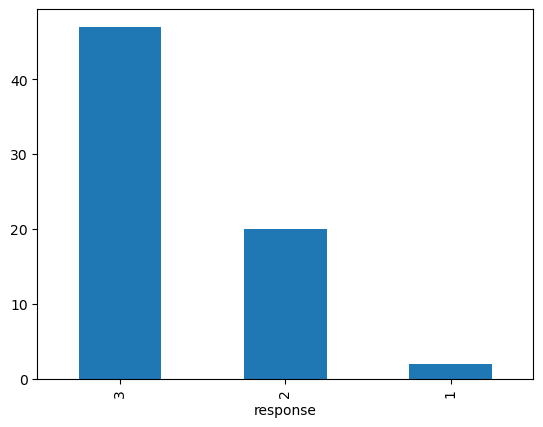

In [ ]:
df_es["response"].value_counts().plot(kind='bar')

In [ ]:
is_there_a_good_market(df_es)

Percentage of positive responses (3-4): 68.12%
Percentage of neutral responses (3): 28.99%
Percentage of negative responses (0-1): 2.90%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.65
Standard deviation of responses: 0.54
VERDICT: There is a good market for bottled gazpacho.


True

So how the target market compares with the Spanish benchmark?

In [ ]:
# compare df with df_es

# % of positive responses (3-4)
percentage_positive = df["response"].astype(str).isin(["3", "4"]).mean()
percentage_positive_es = df_es["response"].astype(str).isin(["3", "4"]).mean()
print(f"Percentage of positive responses (3-4) in the target market: {percentage_positive:.2%}")
print(f"Percentage of positive responses (3-4) in Spain: {percentage_positive_es:.2%}")
# how much more likely are people in Spain to buy the product?
if percentage_positive > 0:
    print(f"Spanish people are {percentage_positive_es / percentage_positive:.2f} times more likely to positively rate the product.")

# % of negative responses (0-1)
percentage_negative = df["response"].astype(str).isin(["0", "1"]).mean()
percentage_negative_es = df_es["response"].astype(str).isin(["0", "1"]).mean()
print(f"Percentage of negative responses (0-1) in the target market: {percentage_negative:.2%}")
print(f"Percentage of negative responses (0-1) in Spain: {percentage_negative_es:.2%}")
# how much more likely are people in Spain to negatively rate the product?
if percentage_negative > 0:
    print(f"Spanish people are {percentage_negative_es / percentage_negative:.2f} times more likely to negatively rate the product.")

Percentage of positive responses (3-4) in the target market: 62.35%
Percentage of positive responses (3-4) in Spain: 68.12%
Spanish people are 1.09 times more likely to positively rate the product.
Percentage of negative responses (0-1) in the target market: 3.53%
Percentage of negative responses (0-1) in Spain: 2.90%
Spanish people are 0.82 times more likely to negatively rate the product.


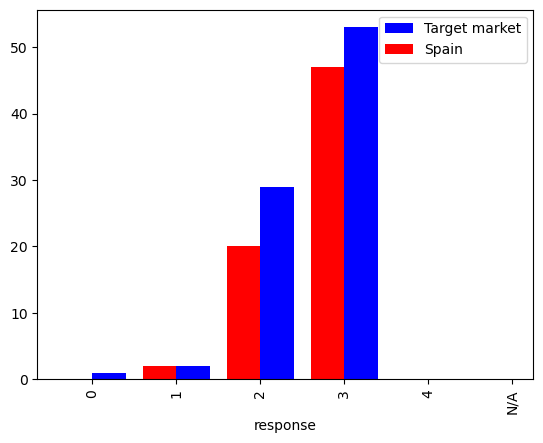

In [ ]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["0", "1", "2", "3", "4", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Target market", ax=ax)
df_es["response"].value_counts().reindex(["0", "1", "2", "3", "4", "N/A"]).plot(kind='bar', color='red', position=1, width=0.4, label="Spain", ax=ax)
plt.legend()
plt.show()


In [ ]:
control.end()